In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit, fsolve, root
from matplotlib.backends.backend_pdf import PdfPages
import pandas_datareader.data as web
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [89]:
def plot_1(M1,M2,title):
    plt.plot(M1, label = "Method 1")
    plt.plot(M2, label = "Method 2")
    plt.xlabel('Year')
    plt.ylabel('Distance to default - Years')
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_2(M1, M2, M3, title):
    plt.plot(M1, label = "Method 1")
    plt.plot(M2, label = "Method 2")
    plt.plot(M3, label = "Method 3")
    plt.xlabel('Year')
    plt.ylabel('Distance to default metrics')
    plt.title(title)
    plt.legend()
    plt.show()
    
def M3Solver(initialconditions, solvedvalues):
    V0 = initialconditions[0]
    E, sigmae, rf, F, sigV, = solvedvalues
    d1 = (np.log(V0/F) + (rf + (sigV**2)/2))/sigV
    d2 = d1 - sigV
    eq1 = V0*norm.cdf(d1) - np.exp(-1*rf)*F*norm.cdf(d2) - E
    return [eq1]

## DSF Data cleaning and calculating Annualised ret, SigmaE & MktCap

In [116]:
path = "D://Data/dsf_new.csv"
df = pd.read_csv(path, usecols = ["CUSIP", "DATE", "PRC", "SHROUT", "RET"], index_col = "DATE")
df.head()

,CUSIP,PRC,RET,SHROUT
DATE,,,,
19860106,68391610,NaN,NaN,NaN
19860107,68391610,-2.5625,C,3680.0
19860108,68391610,-2.5000,-0.024390,3680.0
19860109,68391610,-2.5000,0.000000,3680.0
19860110,68391610,-2.5000,0.000000,3680.0


In [119]:
df.index = pd.to_datetime(df.index, format='%Y%m%d')
df['YEAR'] = df.index.year
df = df[df.YEAR>=1970]
df['CUSIP'] = df['CUSIP'].str[0:6]
df['SHROUT'] = df['SHROUT']*1000
df['MKTCAP'] = abs(df['PRC'])*df['SHROUT']
df.RET = pd.to_numeric(df.RET, errors='coerce')
df.tail()

,CUSIP,PRC,RET,SHROUT,YEAR,MKTCAP
DATE,,,,,,
1995-10-17,NaN,18.625,0.000000,4.438900e+10,1995,8.267451e+11
1995-10-18,NaN,18.875,0.013423,4.438900e+10,1995,8.378424e+11
1995-10-19,NaN,18.750,-0.006623,4.438900e+10,1995,8.322938e+11
1995-10-20,NaN,18.875,0.006667,4.438900e+10,1995,8.378424e+11
1995-10-23,NaN,18.750,-0.006623,4.438900e+10,1995,8.322938e+11


In [120]:
annret = df.groupby(by=['CUSIP','YEAR']).apply(lambda x:np.exp(np.sum(np.log(1 + x['RET']))))
sigmae = df.groupby(by=['CUSIP','YEAR'])['RET'].std()*np.sqrt(250)
MKTCAP = df.groupby(by=['CUSIP','YEAR'])['MKTCAP'].first()

joined = annret.to_frame().join(sigmae).join(MKTCAP)    ## combining the ann ret, sigma and mkt cap data
joined.rename(columns={0: 'Annualised Return', 'RET': 'Sigmae'}, inplace=True)
joined = joined.groupby(['CUSIP']).shift(1)             ## lagging all the data
joined.reset_index(inplace = True)                      ## changing from groupby data to dataframe
joined.head()

,CUSIP,YEAR,Annualised Return,Sigmae,MKTCAP
0,000742,1972,NaN,NaN,NaN
1,000742,1973,1.000000,NaN,1.237500e+10
2,000742,1974,0.585972,0.536087,1.260000e+10
3,000742,1975,0.649569,0.446465,6.750000e+09
4,000742,1976,1.424530,0.519987,4.500000e+09


## Compustat data cleaning and preparation

In [49]:
path = 'D://Data/funda.csv'
use_cols = ['cusip','datadate','dlc','dltt','consol','indfmt','datafmt','popsrc','fic','fyear']
df_funda = pd.read_csv(path,index_col = "datadate", usecols = use_cols)
df_funda.tail()

,fyear,indfmt,consol,popsrc,datafmt,cusip,dlc,dltt,fic
datadate,,,,,,,,,
20181231,2018.0,INDL,C,D,SUMM_STD,21077C107,NaN,0.0,USA
20191231,2019.0,INDL,C,D,STD,21077C107,8.0,42.0,USA
20191231,2019.0,INDL,C,D,SUMM_STD,21077C107,NaN,42.0,USA
20201231,2020.0,INDL,C,D,STD,21077C107,14.0,38.0,USA
20201231,2020.0,INDL,C,D,SUMM_STD,21077C107,NaN,38.0,USA


In [50]:
df_funda.index = pd.to_datetime(df_funda.index, format='%Y%m%d')
df_funda['YEAR'] = df_funda.index.year
df_funda = df_funda[df_funda.YEAR>=1970]
df_funda = df_funda[df_funda.YEAR<=2020]
df_funda = df_funda[df_funda.consol == 'C']
df_funda = df_funda[df_funda.indfmt == 'INDL']
df_funda = df_funda[df_funda.datafmt == 'STD']
df_funda = df_funda[df_funda.popsrc == 'D']
df_funda = df_funda[df_funda.fic == 'USA']
df_funda['cusip'] = df_funda['cusip'].str[0:6]
df_funda['dlc'] = df_funda['dlc']*1000000 
df_funda['dltt'] = df_funda['dltt']*1000000
df_funda = df_funda[['cusip','YEAR','dlc','dltt','fyear']]
df_funda['F'] = df_funda['dlc']+ 0.5*df_funda['dltt']
df_funda.reset_index(inplace = True)
df_funda.head()

,datadate,cusip,YEAR,dlc,dltt,fyear,F
0,1970-12-31,000032,1970,12378000.0,917000.0,1970.0,12836500.0
1,1971-12-31,000032,1971,2857000.0,10318000.0,1971.0,8016000.0
2,1972-12-31,000032,1972,0.0,7000000.0,1972.0,3500000.0
3,1973-12-31,000032,1973,0.0,7000000.0,1973.0,3500000.0
4,1974-12-31,000032,1974,500000.0,7000000.0,1974.0,4000000.0


## Merging the CRSP and COMPUSTAT datasets

In [9]:
merged_data_1 = pd.merge(df_funda, joined, how='right', left_on=['cusip', 'YEAR'],right_on=['CUSIP', 'YEAR'])
merged_data_1['F'].fillna(0,inplace = True)
merged_data_1.tail()

,datadate,cusip,YEAR,dlc,dltt,F,CUSIP,Annualised Return,Sigmae,MKTCAP
6588,NaT,G9032C,1999,NaN,NaN,0.0,G9032C,0.893111,0.370909,454138000.0
6589,NaT,G9032C,2000,NaN,NaN,0.0,G9032C,0.542844,0.469088,359157500.0
6590,NaT,G9032C,2001,NaN,NaN,0.0,G9032C,1.542666,0.499991,167325562.5
6591,NaT,G9032C,2002,NaN,NaN,0.0,G9032C,0.415062,0.680925,881929312.5
6592,NaT,G9032C,2003,NaN,NaN,0.0,G9032C,0.072070,1.481841,383344000.0


In [10]:
merged_data_1['V'] = merged_data_1['MKTCAP'] + merged_data_1['F']
merged_data_1['sigmaNaiveV1'] = (merged_data_1['MKTCAP']/merged_data_1['V'])*merged_data_1['Sigmae'] +(merged_data_1['F']/merged_data_1['V'])*(merged_data_1['Sigmae']*0.25 + 0.05)
merged_data_1['sigmaNaiveV2'] = (merged_data_1['MKTCAP']/merged_data_1['V'])*merged_data_1['Sigmae'] +(merged_data_1['F']/merged_data_1['V'])*(merged_data_1['Sigmae']*0.5 + 0.05)
merged_data_1['sigmaNaiveV3'] = (merged_data_1['MKTCAP']/merged_data_1['V'])*merged_data_1['Sigmae'] +(merged_data_1['F']/merged_data_1['V'])*(merged_data_1['Sigmae']*0.25)
merged_data_1.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data_1['DDNaive1'] = (np.log(merged_data_1['V']/merged_data_1['F']) +merged_data_1['Annualised Return'] - ((merged_data_1['sigmaNaiveV1']**2)/2))/merged_data_1['sigmaNaiveV1']
merged_data_1['DDNaive2'] = (np.log(merged_data_1['V']/merged_data_1['F']) +merged_data_1['Annualised Return'] - ((merged_data_1['sigmaNaiveV2']**2)/2))/merged_data_1['sigmaNaiveV2']
merged_data_1['DDNaive3'] = (np.log(merged_data_1['V']/merged_data_1['F']) +merged_data_1['Annualised Return'] - ((merged_data_1['sigmaNaiveV3']**2)/2))/merged_data_1['sigmaNaiveV3']
merged_data_1.replace([np.inf, -np.inf], np.nan, inplace=True)


merged_data_1['ProbDDNaive1'] = norm.cdf(-1*merged_data_1['DDNaive1'])
merged_data_1['ProbDDNaive2'] = norm.cdf(-1*merged_data_1['DDNaive2'])
merged_data_1['ProbDDNaive3'] = norm.cdf(-1*merged_data_1['DDNaive3'])

In [11]:
merged_data_1.head()

,datadate,cusip,YEAR,dlc,dltt,F,CUSIP,Annualised Return,Sigmae,MKTCAP,V,sigmaNaiveV1,sigmaNaiveV2,sigmaNaiveV3,DDNaive1,DDNaive2,DDNaive3,ProbDDNaive1,ProbDDNaive2,ProbDDNaive3
0,1974-09-30,000774,1974,0.0,0.0,0.0,000774,0.235083,0.917957,11666875.0,11666875.0,0.917957,0.917957,0.917957,NaN,NaN,NaN,NaN,NaN,NaN
1,1975-09-30,000774,1975,0.0,0.0,0.0,000774,0.500001,0.862310,2217062.5,2217062.5,0.862310,0.862310,0.862310,NaN,NaN,NaN,NaN,NaN,NaN
2,1976-09-30,000774,1976,69000.0,0.0,69000.0,000774,1.000000,NaN,1982750.0,2051750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1977-09-30,000774,1977,1000000.0,0.0,1000000.0,000774,2.272725,0.977893,2343250.0,3343250.0,0.773475,0.846599,0.758519,4.112009,3.686871,4.208188,0.00002,0.000114,0.000013
4,1978-09-30,000774,1978,0.0,0.0,0.0,000774,1.159998,0.659749,4506250.0,4506250.0,0.659749,0.659749,0.659749,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
merged_data_1[['sigmaNaiveV1', 'sigmaNaiveV2', 'sigmaNaiveV3','DDNaive1', 'DDNaive2', 'DDNaive3', 'ProbDDNaive1', 'ProbDDNaive2','ProbDDNaive3']].describe()

,sigmaNaiveV1,sigmaNaiveV2,sigmaNaiveV3,DDNaive1,DDNaive2,DDNaive3,ProbDDNaive1,ProbDDNaive2,ProbDDNaive3
count,5952.000000,5952.000000,5952.000000,3656.000000,3656.000000,3655.000000,3.656000e+03,3.656000e+03,3.655000e+03
mean,0.541831,0.568333,0.533916,7.626470,7.080462,8.011782,1.253165e-02,1.795436e-02,1.185350e-02
std,0.397639,0.419057,0.399750,5.001731,4.933312,5.258004,6.580744e-02,8.094151e-02,6.437979e-02
min,0.000000,0.000000,0.000000,-3.503392,-5.107867,-3.483948,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.290088,0.314718,0.280177,4.132791,3.684650,4.292722,7.939065e-24,9.147249e-21,3.213505e-26
50%,0.452140,0.473668,0.445467,6.651872,6.004151,6.997471,1.446982e-11,9.616818e-10,1.303123e-12
75%,0.679864,0.706024,0.673942,9.995944,9.271865,10.527893,1.791920e-05,1.145091e-04,8.824803e-06
max,7.152643,10.316857,7.114537,63.412894,63.412867,63.412918,9.997703e-01,9.999998e-01,9.997530e-01


## Solving unknowns

In [121]:
start = dt.datetime(1970, 1,1)
end = dt.datetime(2020,1,1)
d_fed = web.DataReader("DTB3", "fred", start,end)
d_fed['rf'] = np.log(1+d_fed['DTB3']/100)
d_fed.reset_index(inplace=True)
d_fed['Year'] =pd.DatetimeIndex(d_fed['DATE']).year
d_fed = DAILYFED.groupby('Year')['rf'].first()
d_fed = pd.DataFrame(d_fed)
d_fed.reset_index(inplace=True)

In [122]:
d_fed.head()

,Year,rf
0,1970,0.076220
1,1971,0.047742
2,1972,0.036235
3,1973,0.050883
4,1974,0.072507


In [15]:
merged_data_1 = pd.merge(merged_data_1, d_fed, how='inner', left_on=['YEAR'],right_on=['Year'])
merged_data_12 = merged_data_1.copy()

## Method 2

In [16]:
merged_data_12 = merged_data_12[['Year', 'cusip', 'dlc', 'dltt','F', 'MKTCAP','Annualised Return', 'Sigmae', 'sigmaNaiveV1','sigmaNaiveV2', 'sigmaNaiveV3','DDNaive1', 'DDNaive2', 'DDNaive3','ProbDDNaive1', 'ProbDDNaive2', 'ProbDDNaive3', 'rf','V']]
merged_data_12 = (merged_data_12.groupby(['cusip', 'Year'], as_index=True).mean().groupby(['cusip', 'Year'])['dlc', 'dltt','F', 'MKTCAP','Annualised Return', 'Sigmae', 'sigmaNaiveV1','sigmaNaiveV2', 'sigmaNaiveV3','DDNaive1', 'DDNaive2', 'DDNaive3','ProbDDNaive1', 'ProbDDNaive2', 'ProbDDNaive3', 'rf','V'].mean())
merged_data_12 = merged_data_12.reset_index()

In [17]:
def eqn(vars):
    V2, sigV = vars
    eq1 = V2*norm.cdf((np.log(V2/array[i][1])+array[i][3]+.5*(sigV*sigV))/sigV)-np.exp(-1*array[i][3])*array[i][1]*norm.cdf(((np.log(V2/array[i][1])+array[i][3]+.5*(sigV*sigV))/sigV)-sigV)-array[i][2]
    eq2 = (V2/array[i][2])*norm.cdf((np.log(V2/array[i][1])+array[i][3]+.5*(sigV*sigV))/sigV)*sigV-array[i][0]
    return [eq1, eq2]
array = merged_data_12[['Sigmae','F','MKTCAP','rf', 'V', 'sigmaNaiveV1']].to_numpy()
v_ls = []
sigV_ls = []
for i in range(array.shape[0]):
    V2, sigV = fsolve(eqn, (array[i][4], array[i][5]))
    v_ls.append(V2)
    sigV_ls.append(sigV)
    
V_df = pd.DataFrame({'V2':v_ls})
sigV_df = pd.DataFrame({'sigV':sigV_ls})
df_c = pd.concat([V_df.reset_index(drop=True), sigV_df], axis=1)
df_method2 = pd.concat([df_c.reset_index(drop=True), merged_data_12], axis=1)

In [18]:
df_method2 = df_method2[df_method2.V2 != 100000]
df_method2 = df_method2[df_method2.sigV != 0.1]
df_method2.replace([np.inf, -np.inf], np.nan, inplace=True)
df_method2.dropna(inplace = True)
df_method2.head()

,V2,sigV,cusip,Year,dlc,dltt,F,MKTCAP,Annualised Return,Sigmae,...,sigmaNaiveV2,sigmaNaiveV3,DDNaive1,DDNaive2,DDNaive3,ProbDDNaive1,ProbDDNaive2,ProbDDNaive3,rf,V
13,3.280754e+06,0.711618,000774,1977,1000000.0,0.0,1000000.0,2343250.0,2.272725,0.977893,...,0.846599,0.758519,4.112009,3.686871,4.208188,1.961152e-05,1.135141e-04,1.287135e-05,0.042964,3343250.0
22,9.538288e+06,0.164188,000781,1983,5147000.0,2022000.0,6158000.0,3832500.0,0.485713,0.408360,...,0.313326,0.219580,3.747008,2.937869,4.305904,8.947837e-05,1.652383e-03,8.315251e-06,0.076220,9990500.0
23,6.896780e+06,0.156579,000781,1984,4468000.0,2058000.0,5497000.0,1861500.0,2.303071,0.569168,...,0.393927,0.250280,8.877192,6.389847,10.242148,3.428458e-19,8.302609e-11,6.417724e-25,0.086178,7358500.0
24,8.975520e+06,0.147604,000781,1985,4454000.0,1475000.0,5191500.0,4161000.0,1.470722,0.318387,...,0.257775,0.185837,9.534718,7.860034,10.988552,7.514640e-22,1.920142e-15,2.169162e-28,0.075386,9352500.0
25,1.248655e+07,0.148300,000781,1986,4886000.0,4074000.0,6923000.0,6022500.0,1.967877,0.307472,...,0.251996,0.184150,12.193826,10.166922,13.993083,1.676514e-34,1.392870e-24,8.590047e-45,0.068593,12945500.0


In [19]:
df_method2['DDMethod2'] = (np.log(df_method2['V2']/df_method2['F']) +df_method2['Annualised Return'] - ((df_method2['sigV']**2)/2))/df_method2['sigV']
df_method2['ProbDDMethod2'] = norm.cdf(-1*df_method2['DDMethod2'])
df_method2.tail()

,V2,sigV,cusip,Year,dlc,dltt,F,MKTCAP,Annualised Return,Sigmae,...,DDNaive1,DDNaive2,DDNaive3,ProbDDNaive1,ProbDDNaive2,ProbDDNaive3,rf,V,DDMethod2,ProbDDMethod2
6378,7.567496e+08,0.718768,98419J,2015,6019000.0,42930000.0,27484000.0,729271120.0,0.533432,0.745851,...,4.927952,4.875753,4.942104,4.154798e-07,5.419709e-07,3.864192e-07,0.000200,756755120.0,4.995418,2.935430e-07
6379,4.414487e+08,1.200301,98419J,2016,17959000.0,25381000.0,30649500.0,411416600.0,0.370473,1.284868,...,1.877377,1.821690,1.886192,3.023322e-02,3.425099e-02,2.963457e-02,0.002198,442066100.0,1.930813,2.675309e-02
6380,1.667692e+08,0.736290,98419J,2017,0.0,14572000.0,7286000.0,159521640.0,0.158647,0.769740,...,4.032030,3.978789,4.046044,2.764861e-05,3.463354e-05,2.604521e-05,0.005286,166807640.0,4.099260,2.072368e-05
6381,4.175321e+07,0.636111,98419J,2018,789000.0,21690000.0,11634000.0,30386580.0,8.436024,0.865834,...,13.538343,12.412958,13.825507,4.642987e-42,1.111430e-35,8.942441e-44,0.014100,42020580.0,14.952656,7.482960e-51
6382,3.149593e+08,0.681041,98419J,2019,5347000.0,27501000.0,19097500.0,296304080.0,0.355336,0.723917,...,4.205284,4.129048,4.226742,1.303772e-05,1.821340e-05,1.185498e-05,0.023424,315401580.0,4.296823,8.663174e-06


In [20]:
#df_method2.replace([np.inf, -np.inf], np.nan, inplace=True)
#df_method2 = df_method2.dropna(inplace = True)
df_method_DD = df_method2.copy()
plot_data = df_method_DD[['Year','DDNaive1', 'ProbDDNaive1', 'DDMethod2','ProbDDMethod2']]
plot_data['yearD'] = plot_data['Year']

In [21]:
plot_data[['DDNaive1','DDMethod2']].corr()

,DDNaive1,DDMethod2
DDNaive1,1.00000,0.72495
DDMethod2,0.72495,1.00000


In [22]:
plot_data[['ProbDDNaive1','ProbDDMethod2']].corr()

,ProbDDNaive1,ProbDDMethod2
ProbDDNaive1,1.000000,0.942159
ProbDDMethod2,0.942159,1.000000


In [23]:
plot_data[['ProbDDNaive1','ProbDDMethod2','DDNaive1','DDMethod2']].describe()

,ProbDDNaive1,ProbDDMethod2,DDNaive1,DDMethod2
count,3.596000e+03,3.596000e+03,3596.000000,3596.000000
mean,1.264412e-02,1.550261e-02,7.555008,9.046766
std,6.620550e-02,8.853645e-02,4.917283,7.784788
min,0.000000e+00,0.000000e+00,-3.503392,-8.358649
25%,2.665233e-23,1.030843e-31,4.114530,4.608767
50%,1.884313e-11,1.546483e-14,6.615037,7.594387
75%,1.939881e-05,2.025322e-06,9.887942,11.659119
max,9.997703e-01,1.000000e+00,63.412894,201.394944


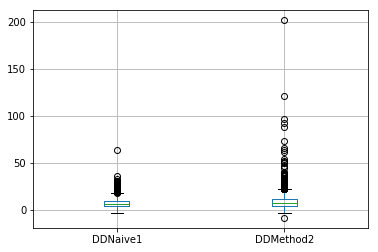

In [24]:
plot_data.boxplot(['DDNaive1','DDMethod2'])

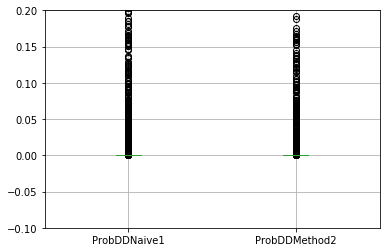

In [25]:
plt.ylim(-0.1, 0.2)
plot_data.boxplot(['ProbDDNaive1','ProbDDMethod2'])

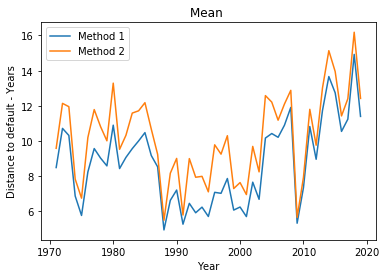

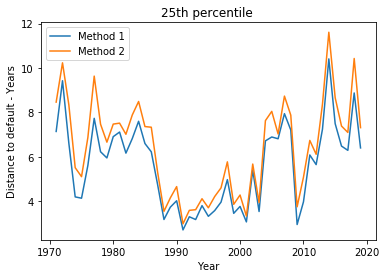

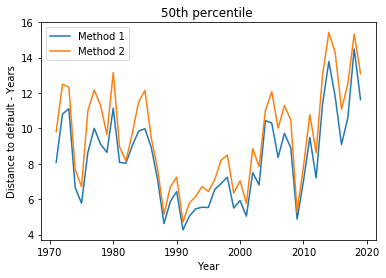

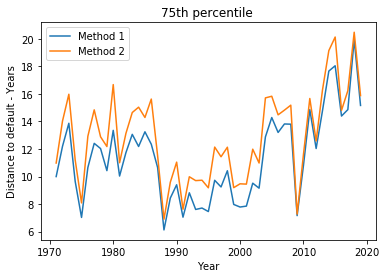

In [26]:
DD_mean = plot_data.copy()
DD_mean = (DD_mean.groupby(['Year'], as_index=False).mean().groupby(['Year'])['DDNaive1', 'ProbDDNaive1', 'DDMethod2','ProbDDMethod2'].mean())
DD_25th = plot_data.copy()
DD_25th = (DD_25th.groupby(['Year'], as_index=False).quantile(0.25).groupby(['Year'])['DDNaive1', 'ProbDDNaive1', 'DDMethod2','ProbDDMethod2'].quantile(0.25))
DD_50th = plot_data.copy()
DD_50th = (DD_50th.groupby(['Year'], as_index=False).quantile(0.50).groupby(['Year'])['DDNaive1', 'ProbDDNaive1', 'DDMethod2','ProbDDMethod2'].quantile(0.50))
DD_75th = plot_data.copy()
DD_75th = (DD_75th.groupby(['Year'], as_index=False).quantile(0.75).groupby(['Year'])['DDNaive1', 'ProbDDNaive1', 'DDMethod2','ProbDDMethod2'].quantile(0.75))
plot_1(DD_mean.iloc[:,0],DD_mean.iloc[:,2],"Mean ")
plot_1(DD_25th.iloc[:,0],DD_25th.iloc[:,2],"25th percentile ")
plot_1(DD_50th.iloc[:,0],DD_50th.iloc[:,2],"50th percentile ")
plot_1(DD_75th.iloc[:,0],DD_75th.iloc[:,2],"75th percentile ")

## Method 3

In [69]:
path = "D://Data/dsf_new.csv"
df = pd.read_csv(path, nrows = 1000000, usecols = ["CUSIP", "DATE", "PRC", "SHROUT", "RET"], index_col = "DATE")
df

df['CUSIP'] = df['CUSIP'].astype(str).str[0:6]
df['SHROUT'] = df['SHROUT']*1000
df['DATE'] = pd.to_datetime(df.index,format='%Y%m%d')
df['YEAR'] = pd.DatetimeIndex(df['DATE']).year
df['E'] = abs(df['PRC']) * df['SHROUT']
E = df.groupby(by = ['CUSIP','YEAR'])['E'].first()
df[["RET"]] = df[["RET"]].apply(pd.to_numeric, errors = 'coerce')

annual_return= df.groupby(by = ['CUSIP','YEAR']).apply(lambda x: np.exp(np.sum(np.log(1+ x['RET'])))).to_frame().reset_index()
annual_return = annual_return.set_axis(['CUSIP', 'YEAR', 'annual_return'], axis = 1,inplace = False)
df = pd.merge(df, annual_return, how='inner', left_on=['CUSIP','YEAR'], right_on =['CUSIP','YEAR'])
sigmae = df.groupby(by = ['CUSIP','YEAR'])['RET'].std()*np.sqrt(250)
sigmae = sigmae.to_frame().reset_index()
sigmae = sigmae.set_axis(['CUSIP', 'YEAR', 'sigmae'], axis = 1,inplace = False)
df = pd.merge(df, sigmae, how='inner', left_on=['CUSIP','YEAR'], right_on =['CUSIP','YEAR'])
df['sigmae'].replace([np.inf, -np.inf, 0], np.nan, inplace=True)

In [70]:
combined = pd.merge(df_funda, df, how='inner', left_on=['cusip', 'fyear'],right_on=['CUSIP', 'YEAR'])

In [123]:
combined.head()

,datadate,cusip,YEAR_x,dlc,dltt,fyear,F,CUSIP,PRC,RET,...,E,annual_return,sigmae,V,sigmaNaiveV1,sigmaNaiveV2,sigmaNaiveV3,DDNaive1,DDNaive2,DDNaive3
2705,1982-10-31,000781,1982,16950000.0,0.0,1982.0,16950000.0,000781,-4.375,NaN,...,3832500.0,0.485713,0.40836,20782500.0,0.199349,0.282612,0.158569,3.359374,2.298633,4.269333
2706,1982-10-31,000781,1982,16950000.0,0.0,1982.0,16950000.0,000781,-4.375,0.000000,...,3832500.0,0.485713,0.40836,20782500.0,0.199349,0.282612,0.158569,3.359374,2.298633,4.269333
2707,1982-10-31,000781,1982,16950000.0,0.0,1982.0,16950000.0,000781,-4.500,0.028571,...,3942000.0,0.485713,0.40836,20892000.0,0.200444,0.283271,0.159878,3.366139,2.311178,4.265938
2708,1982-10-31,000781,1982,16950000.0,0.0,1982.0,16950000.0,000781,-4.500,0.000000,...,3942000.0,0.485713,0.40836,20892000.0,0.200444,0.283271,0.159878,3.366139,2.311178,4.265938
2709,1982-10-31,000781,1982,16950000.0,0.0,1982.0,16950000.0,000781,-4.500,0.000000,...,3942000.0,0.485713,0.40836,20892000.0,0.200444,0.283271,0.159878,3.366139,2.311178,4.265938


In [74]:
uniquestocks = combined.copy()
uniquestocks.set_index('YEAR_x', inplace=True)
uniquestocks = uniquestocks.loc[1990]['cusip'].unique()
stock_list = np.random.choice(uniquestocks, 250) 
combined = combined[combined['CUSIP'].isin(stock_list)]

print(stock_list)

['696705' '107090' '466032' '810022' '625912' '699556' '758848' '00509L'
 '013902' '600404' '004325' '74368L' '013902' '74368L' '281900' '872555'
 '74368L' '741910' '268648' '024618' '590175' '004527' '830506' '002067'
 '23335Q' '589774' '74368L' '013902' '834447' '682419' '742918' '893658'
 '758848' '902128' '729132' '962901' '00208K' '553533' '371855' '812138'
 '651633' '74368L' '027559' '013902' '90130N' '002067' '453235' '107090'
 '688402' '662488' '534735' '615762' '36473U' '017361' '595433' '90130N'
 '640902' '001030' '027135' '72356K' '749371' '00509L' '866810' '576152'
 '449507' '421918' '192428' '74144T' '584131' '834447' '303031' '822824'
 '742918' '004626' '981556' '027559' '74144T' '729132' '034258' '319588'
 '463347' '89323N' '232806' '670773' '026913' '85208J' '438516' '024618'
 '32054T' '047659' '699556' '456626' '024618' '289660' '027559' '878237'
 '35242V' '438516' '007422' '696705' '034258' '232806' '799778' '203630'
 '456834' '576152' '41043F' '369386' '595433' '7275

In [76]:
combined.head()
combined['V'] = combined['E'] + combined['F']
combined['sigmaNaiveV1'] = (combined['E']/combined['V'])*combined['sigmae'] +(combined['F']/combined['V'])*(combined['sigmae']*0.25 + 0.05)
combined['sigmaNaiveV2'] = (combined['E']/combined['V'])*combined['sigmae'] +(combined['F']/combined['V'])*(combined['sigmae']*0.5 + 0.05)
combined['sigmaNaiveV3'] = (combined['E']/combined['V'])*combined['sigmae'] +(combined['F']/combined['V'])*(combined['sigmae']*0.25)
combined.replace([np.inf, -np.inf], np.nan, inplace=True)
combined['DDNaive1'] = (np.log(combined['V']/combined['F']) +combined['annual_return'] - ((combined['sigmaNaiveV1']**2)/2))/combined['sigmaNaiveV1']
combined['DDNaive2'] = (np.log(combined['V']/combined['F']) +combined['annual_return'] - ((combined['sigmaNaiveV2']**2)/2))/combined['sigmaNaiveV2']
combined['DDNaive3'] = (np.log(combined['V']/combined['F']) +combined['annual_return'] - ((combined['sigmaNaiveV3']**2)/2))/combined['sigmaNaiveV3']
combined.replace([np.inf, -np.inf], np.nan, inplace=True)

In [84]:
data_list = []
i = 0
for s in stock_list:
    i = i + 1
    for year in range (1970, 2020, 1):
        DSF_COMPSTAT_SLICE = combined[(combined['cusip'] == s) &(combined['YEAR_x'] == year)]
        DSF_COMPSTAT_SLICE.set_index('YEAR_x', inplace=True)
        NAttempts = 0
        ErrorTolerance = 1
        while((ErrorTolerance > 0.01) & (NAttempts < 5)):
            StockArray = []
            for index, row in DSF_COMPSTAT_SLICE.iterrows():  
                if NAttempts == 0:
                    sigV3 = row['sigmaNaiveV1']
                else:
                    sigV3 = sigV3_solved
                V = root(M3Solver, [row['V']],args = [row['E'], row['sigmae'], row['annual_return'], row['F'],sigV3]).x[0]
                StockArray.append(V)
            df_V = pd.DataFrame(StockArray, columns=['V'])
            sigV3_solved = ((df_V.pct_change() + 1).std()*np.sqrt(len(StockArray)))[0]
            ErrorTolerance = abs(sigV3_solved - sigV3)
            NAttempts = NAttempts + 1
        data_list.append((year, s, sigV3_solved))

Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Colu

         datadate   cusip  YEAR_x  dlc  dltt   fyear   F   CUSIP     PRC  \
758613 1987-12-31  696705    1987  NaN   NaN  1987.0 NaN  696705 -12.000   
758614 1987-12-31  696705    1987  NaN   NaN  1987.0 NaN  696705 -12.000   
758615 1987-12-31  696705    1987  NaN   NaN  1987.0 NaN  696705 -12.000   
758616 1987-12-31  696705    1987  NaN   NaN  1987.0 NaN  696705  11.000   
758617 1987-12-31  696705    1987  NaN   NaN  1987.0 NaN  696705 -11.625   
758618 1987-12-31  696705    1987  NaN   NaN  1987.0 NaN  696705 -11.125   
758619 1987-12-31  696705    1987  NaN   NaN  1987.0 NaN  696705 -11.125   
758620 1987-12-31  696705    1987  NaN   NaN  1987.0 NaN  696705 -11.125   
758621 1987-12-31  696705    1987  NaN   NaN  1987.0 NaN  696705 -11.125   
758622 1987-12-31  696705    1987  NaN   NaN  1987.0 NaN  696705 -11.375   
758623 1987-12-31  696705    1987  NaN   NaN  1987.0 NaN  696705 -11.375   
758624 1987-12-31  696705    1987  NaN   NaN  1987.0 NaN  696705  11.750   
758625 1987-

         datadate   cusip  YEAR_x  dlc  dltt   fyear   F   CUSIP    PRC  \
758866 1988-12-31  696705    1988  NaN   NaN  1988.0 NaN  696705    NaN   
758867 1988-12-31  696705    1988  NaN   NaN  1988.0 NaN  696705    NaN   
758868 1988-12-31  696705    1988  NaN   NaN  1988.0 NaN  696705    NaN   
758869 1988-12-31  696705    1988  NaN   NaN  1988.0 NaN  696705    NaN   
758870 1988-12-31  696705    1988  NaN   NaN  1988.0 NaN  696705    NaN   
758871 1988-12-31  696705    1988  NaN   NaN  1988.0 NaN  696705    NaN   
758872 1988-12-31  696705    1988  NaN   NaN  1988.0 NaN  696705    NaN   
758873 1988-12-31  696705    1988  NaN   NaN  1988.0 NaN  696705    NaN   
758874 1988-12-31  696705    1988  NaN   NaN  1988.0 NaN  696705    NaN   
758875 1988-12-31  696705    1988  NaN   NaN  1988.0 NaN  696705    NaN   
758876 1988-12-31  696705    1988  NaN   NaN  1988.0 NaN  696705    NaN   
758877 1988-12-31  696705    1988  NaN   NaN  1988.0 NaN  696705    NaN   
758878 1988-12-31  696705

         datadate   cusip  YEAR_x  dlc  dltt   fyear   F   CUSIP    PRC  \
759119 1989-12-31  696705    1989  NaN   NaN  1989.0 NaN  696705 -5.500   
759120 1989-12-31  696705    1989  NaN   NaN  1989.0 NaN  696705 -5.500   
759121 1989-12-31  696705    1989  NaN   NaN  1989.0 NaN  696705 -5.500   
759122 1989-12-31  696705    1989  NaN   NaN  1989.0 NaN  696705 -5.500   
759123 1989-12-31  696705    1989  NaN   NaN  1989.0 NaN  696705 -5.500   
759124 1989-12-31  696705    1989  NaN   NaN  1989.0 NaN  696705 -5.500   
759125 1989-12-31  696705    1989  NaN   NaN  1989.0 NaN  696705 -5.500   
759126 1989-12-31  696705    1989  NaN   NaN  1989.0 NaN  696705 -5.500   
759127 1989-12-31  696705    1989  NaN   NaN  1989.0 NaN  696705 -5.500   
759128 1989-12-31  696705    1989  NaN   NaN  1989.0 NaN  696705 -5.500   
759129 1989-12-31  696705    1989  NaN   NaN  1989.0 NaN  696705 -5.500   
759130 1989-12-31  696705    1989  NaN   NaN  1989.0 NaN  696705 -5.500   
759131 1989-12-31  696705

         datadate   cusip  YEAR_x  dlc  dltt   fyear   F   CUSIP    PRC  RET  \
759371 1990-12-31  696705    1990  NaN   NaN  1990.0 NaN  696705 -5.875  0.0   
759372 1990-12-31  696705    1990  NaN   NaN  1990.0 NaN  696705 -5.875  0.0   
759373 1990-12-31  696705    1990  NaN   NaN  1990.0 NaN  696705 -5.875  0.0   
759374 1990-12-31  696705    1990  NaN   NaN  1990.0 NaN  696705 -5.875  0.0   
759375 1990-12-31  696705    1990  NaN   NaN  1990.0 NaN  696705 -5.875  0.0   
759376 1990-12-31  696705    1990  NaN   NaN  1990.0 NaN  696705 -5.875  0.0   
759377 1990-12-31  696705    1990  NaN   NaN  1990.0 NaN  696705 -5.875  0.0   
759378 1990-12-31  696705    1990  NaN   NaN  1990.0 NaN  696705 -5.875  0.0   
759379 1990-12-31  696705    1990  NaN   NaN  1990.0 NaN  696705 -5.875  0.0   
759380 1990-12-31  696705    1990  NaN   NaN  1990.0 NaN  696705 -5.875  0.0   
759381 1990-12-31  696705    1990  NaN   NaN  1990.0 NaN  696705 -5.875  0.0   
759382 1990-12-31  696705    1990  NaN  

         datadate   cusip  YEAR_x  dlc  dltt   fyear   F   CUSIP   PRC  \
759624 1991-12-31  696705    1991  NaN   NaN  1991.0 NaN  696705 -5.75   
759625 1991-12-31  696705    1991  NaN   NaN  1991.0 NaN  696705 -5.75   
759626 1991-12-31  696705    1991  NaN   NaN  1991.0 NaN  696705 -5.75   
759627 1991-12-31  696705    1991  NaN   NaN  1991.0 NaN  696705 -5.75   
759628 1991-12-31  696705    1991  NaN   NaN  1991.0 NaN  696705 -5.75   
759629 1991-12-31  696705    1991  NaN   NaN  1991.0 NaN  696705 -5.75   
759630 1991-12-31  696705    1991  NaN   NaN  1991.0 NaN  696705 -5.75   
759631 1991-12-31  696705    1991  NaN   NaN  1991.0 NaN  696705 -5.75   
759632 1991-12-31  696705    1991  NaN   NaN  1991.0 NaN  696705 -5.75   
759633 1991-12-31  696705    1991  NaN   NaN  1991.0 NaN  696705 -5.75   
759634 1991-12-31  696705    1991  NaN   NaN  1991.0 NaN  696705 -5.75   
759635 1991-12-31  696705    1991  NaN   NaN  1991.0 NaN  696705 -5.75   
759636 1991-12-31  696705    1991  NaN

         datadate   cusip  YEAR_x  dlc  dltt   fyear   F   CUSIP     PRC  \
759877 1992-12-31  696705    1992  NaN   NaN  1992.0 NaN  696705 -5.7500   
759878 1992-12-31  696705    1992  NaN   NaN  1992.0 NaN  696705 -5.7500   
759879 1992-12-31  696705    1992  NaN   NaN  1992.0 NaN  696705 -5.7500   
759880 1992-12-31  696705    1992  NaN   NaN  1992.0 NaN  696705 -5.7500   
759881 1992-12-31  696705    1992  NaN   NaN  1992.0 NaN  696705 -5.7500   
759882 1992-12-31  696705    1992  NaN   NaN  1992.0 NaN  696705 -5.7500   
759883 1992-12-31  696705    1992  NaN   NaN  1992.0 NaN  696705 -5.7500   
759884 1992-12-31  696705    1992  NaN   NaN  1992.0 NaN  696705 -5.7500   
759885 1992-12-31  696705    1992  NaN   NaN  1992.0 NaN  696705 -5.7500   
759886 1992-12-31  696705    1992  NaN   NaN  1992.0 NaN  696705 -5.7500   
759887 1992-12-31  696705    1992  NaN   NaN  1992.0 NaN  696705 -5.7500   
759888 1992-12-31  696705    1992  NaN   NaN  1992.0 NaN  696705 -5.7500   
759889 1992-

         datadate   cusip  YEAR_x        dlc       dltt   fyear          F  \
760131 1993-12-31  696705    1993  5600000.0  7000000.0  1993.0  9100000.0   
760132 1993-12-31  696705    1993  5600000.0  7000000.0  1993.0  9100000.0   
760133 1993-12-31  696705    1993  5600000.0  7000000.0  1993.0  9100000.0   
760134 1993-12-31  696705    1993  5600000.0  7000000.0  1993.0  9100000.0   
760135 1993-12-31  696705    1993  5600000.0  7000000.0  1993.0  9100000.0   
760136 1993-12-31  696705    1993  5600000.0  7000000.0  1993.0  9100000.0   
760137 1993-12-31  696705    1993  5600000.0  7000000.0  1993.0  9100000.0   
760138 1993-12-31  696705    1993  5600000.0  7000000.0  1993.0  9100000.0   
760139 1993-12-31  696705    1993  5600000.0  7000000.0  1993.0  9100000.0   
760140 1993-12-31  696705    1993  5600000.0  7000000.0  1993.0  9100000.0   
760141 1993-12-31  696705    1993  5600000.0  7000000.0  1993.0  9100000.0   
760142 1993-12-31  696705    1993  5600000.0  7000000.0  1993.0 

         datadate   cusip  YEAR_x         dlc        dltt   fyear           F  \
760384 1994-12-31  696705    1994  12400000.0  10000000.0  1994.0  17400000.0   
760385 1994-12-31  696705    1994  12400000.0  10000000.0  1994.0  17400000.0   
760386 1994-12-31  696705    1994  12400000.0  10000000.0  1994.0  17400000.0   
760387 1994-12-31  696705    1994  12400000.0  10000000.0  1994.0  17400000.0   
760388 1994-12-31  696705    1994  12400000.0  10000000.0  1994.0  17400000.0   
760389 1994-12-31  696705    1994  12400000.0  10000000.0  1994.0  17400000.0   
760390 1994-12-31  696705    1994  12400000.0  10000000.0  1994.0  17400000.0   
760391 1994-12-31  696705    1994  12400000.0  10000000.0  1994.0  17400000.0   
760392 1994-12-31  696705    1994  12400000.0  10000000.0  1994.0  17400000.0   
760393 1994-12-31  696705    1994  12400000.0  10000000.0  1994.0  17400000.0   
760394 1994-12-31  696705    1994  12400000.0  10000000.0  1994.0  17400000.0   
760395 1994-12-31  696705   

         datadate   cusip  YEAR_x         dlc  dltt   fyear           F  \
760636 1995-12-31  696705    1995  10000000.0   0.0  1995.0  10000000.0   
760637 1995-12-31  696705    1995  10000000.0   0.0  1995.0  10000000.0   
760638 1995-12-31  696705    1995  10000000.0   0.0  1995.0  10000000.0   
760639 1995-12-31  696705    1995  10000000.0   0.0  1995.0  10000000.0   
760640 1995-12-31  696705    1995  10000000.0   0.0  1995.0  10000000.0   
760641 1995-12-31  696705    1995  10000000.0   0.0  1995.0  10000000.0   
760642 1995-12-31  696705    1995  10000000.0   0.0  1995.0  10000000.0   
760643 1995-12-31  696705    1995  10000000.0   0.0  1995.0  10000000.0   
760644 1995-12-31  696705    1995  10000000.0   0.0  1995.0  10000000.0   
760645 1995-12-31  696705    1995  10000000.0   0.0  1995.0  10000000.0   
760646 1995-12-31  696705    1995  10000000.0   0.0  1995.0  10000000.0   
760647 1995-12-31  696705    1995  10000000.0   0.0  1995.0  10000000.0   
760648 1995-12-31  696705

Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Colu

Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Colu

         datadate   cusip  YEAR_x         dlc        dltt   fyear           F  \
468420 1988-01-31  107090    1988  10865000.0  13219000.0  1987.0  17474500.0   
468421 1988-01-31  107090    1988  10865000.0  13219000.0  1987.0  17474500.0   
468422 1988-01-31  107090    1988  10865000.0  13219000.0  1987.0  17474500.0   
468423 1988-01-31  107090    1988  10865000.0  13219000.0  1987.0  17474500.0   
468424 1988-01-31  107090    1988  10865000.0  13219000.0  1987.0  17474500.0   
468425 1988-01-31  107090    1988  10865000.0  13219000.0  1987.0  17474500.0   
468426 1988-01-31  107090    1988  10865000.0  13219000.0  1987.0  17474500.0   
468427 1988-01-31  107090    1988  10865000.0  13219000.0  1987.0  17474500.0   
468428 1988-01-31  107090    1988  10865000.0  13219000.0  1987.0  17474500.0   
468429 1988-01-31  107090    1988  10865000.0  13219000.0  1987.0  17474500.0   
468430 1988-01-31  107090    1988  10865000.0  13219000.0  1987.0  17474500.0   
468431 1988-01-31  107090   

         datadate   cusip  YEAR_x        dlc        dltt   fyear          F  \
468673 1989-01-31  107090    1989  1020000.0  12196000.0  1988.0  7118000.0   
468674 1989-01-31  107090    1989  1020000.0  12196000.0  1988.0  7118000.0   
468675 1989-01-31  107090    1989  1020000.0  12196000.0  1988.0  7118000.0   
468676 1989-01-31  107090    1989  1020000.0  12196000.0  1988.0  7118000.0   
468677 1989-01-31  107090    1989  1020000.0  12196000.0  1988.0  7118000.0   
468678 1989-01-31  107090    1989  1020000.0  12196000.0  1988.0  7118000.0   
468679 1989-01-31  107090    1989  1020000.0  12196000.0  1988.0  7118000.0   
468680 1989-01-31  107090    1989  1020000.0  12196000.0  1988.0  7118000.0   
468681 1989-01-31  107090    1989  1020000.0  12196000.0  1988.0  7118000.0   
468682 1989-01-31  107090    1989  1020000.0  12196000.0  1988.0  7118000.0   
468683 1989-01-31  107090    1989  1020000.0  12196000.0  1988.0  7118000.0   
468684 1989-01-31  107090    1989  1020000.0  121960

         datadate   cusip  YEAR_x         dlc        dltt   fyear           F  \
468926 1990-01-31  107090    1990  15181000.0  10634000.0  1989.0  20498000.0   
468927 1990-01-31  107090    1990  15181000.0  10634000.0  1989.0  20498000.0   
468928 1990-01-31  107090    1990  15181000.0  10634000.0  1989.0  20498000.0   
468929 1990-01-31  107090    1990  15181000.0  10634000.0  1989.0  20498000.0   
468930 1990-01-31  107090    1990  15181000.0  10634000.0  1989.0  20498000.0   
468931 1990-01-31  107090    1990  15181000.0  10634000.0  1989.0  20498000.0   
468932 1990-01-31  107090    1990  15181000.0  10634000.0  1989.0  20498000.0   
468933 1990-01-31  107090    1990  15181000.0  10634000.0  1989.0  20498000.0   
468934 1990-01-31  107090    1990  15181000.0  10634000.0  1989.0  20498000.0   
468935 1990-01-31  107090    1990  15181000.0  10634000.0  1989.0  20498000.0   
468936 1990-01-31  107090    1990  15181000.0  10634000.0  1989.0  20498000.0   
468937 1990-01-31  107090   

         datadate   cusip  YEAR_x         dlc       dltt   fyear           F  \
469178 1991-01-31  107090    1991  50426000.0  9557000.0  1990.0  55204500.0   
469179 1991-01-31  107090    1991  50426000.0  9557000.0  1990.0  55204500.0   
469180 1991-01-31  107090    1991  50426000.0  9557000.0  1990.0  55204500.0   
469181 1991-01-31  107090    1991  50426000.0  9557000.0  1990.0  55204500.0   
469182 1991-01-31  107090    1991  50426000.0  9557000.0  1990.0  55204500.0   
469183 1991-01-31  107090    1991  50426000.0  9557000.0  1990.0  55204500.0   
469184 1991-01-31  107090    1991  50426000.0  9557000.0  1990.0  55204500.0   
469185 1991-01-31  107090    1991  50426000.0  9557000.0  1990.0  55204500.0   
469186 1991-01-31  107090    1991  50426000.0  9557000.0  1990.0  55204500.0   
469187 1991-01-31  107090    1991  50426000.0  9557000.0  1990.0  55204500.0   
469188 1991-01-31  107090    1991  50426000.0  9557000.0  1990.0  55204500.0   
469189 1991-01-31  107090    1991  50426

         datadate   cusip  YEAR_x         dlc        dltt   fyear           F  \
469431 1992-01-31  107090    1992  28443000.0  14973000.0  1991.0  35929500.0   
469432 1992-01-31  107090    1992  28443000.0  14973000.0  1991.0  35929500.0   
469433 1992-01-31  107090    1992  28443000.0  14973000.0  1991.0  35929500.0   
469434 1992-01-31  107090    1992  28443000.0  14973000.0  1991.0  35929500.0   
469435 1992-01-31  107090    1992  28443000.0  14973000.0  1991.0  35929500.0   
469436 1992-01-31  107090    1992  28443000.0  14973000.0  1991.0  35929500.0   
469437 1992-01-31  107090    1992  28443000.0  14973000.0  1991.0  35929500.0   
469438 1992-01-31  107090    1992  28443000.0  14973000.0  1991.0  35929500.0   
469439 1992-01-31  107090    1992  28443000.0  14973000.0  1991.0  35929500.0   
469440 1992-01-31  107090    1992  28443000.0  14973000.0  1991.0  35929500.0   
469441 1992-01-31  107090    1992  28443000.0  14973000.0  1991.0  35929500.0   
469442 1992-01-31  107090   

         datadate   cusip  YEAR_x  dlc  dltt   fyear    F   CUSIP     PRC  \
469684 1993-01-31  107090    1993  0.0   0.0  1992.0  0.0  107090  2.2500   
469685 1993-01-31  107090    1993  0.0   0.0  1992.0  0.0  107090  2.7500   
469686 1993-01-31  107090    1993  0.0   0.0  1992.0  0.0  107090  2.7500   
469687 1993-01-31  107090    1993  0.0   0.0  1992.0  0.0  107090  2.2500   
469688 1993-01-31  107090    1993  0.0   0.0  1992.0  0.0  107090  2.5000   
469689 1993-01-31  107090    1993  0.0   0.0  1992.0  0.0  107090  2.7500   
469690 1993-01-31  107090    1993  0.0   0.0  1992.0  0.0  107090 -2.5000   
469691 1993-01-31  107090    1993  0.0   0.0  1992.0  0.0  107090  2.3750   
469692 1993-01-31  107090    1993  0.0   0.0  1992.0  0.0  107090  2.2500   
469693 1993-01-31  107090    1993  0.0   0.0  1992.0  0.0  107090  2.0000   
469694 1993-01-31  107090    1993  0.0   0.0  1992.0  0.0  107090  2.0000   
469695 1993-01-31  107090    1993  0.0   0.0  1992.0  0.0  107090  2.5000   

         datadate   cusip  YEAR_x  dlc  dltt   fyear    F   CUSIP     PRC  \
469938 1994-01-31  107090    1994  0.0   0.0  1993.0  0.0  107090  0.7500   
469939 1994-01-31  107090    1994  0.0   0.0  1993.0  0.0  107090  1.0000   
469940 1994-01-31  107090    1994  0.0   0.0  1993.0  0.0  107090  1.0000   
469941 1994-01-31  107090    1994  0.0   0.0  1993.0  0.0  107090  1.0000   
469942 1994-01-31  107090    1994  0.0   0.0  1993.0  0.0  107090  1.0000   
469943 1994-01-31  107090    1994  0.0   0.0  1993.0  0.0  107090  1.0000   
469944 1994-01-31  107090    1994  0.0   0.0  1993.0  0.0  107090  0.7500   
469945 1994-01-31  107090    1994  0.0   0.0  1993.0  0.0  107090  1.0000   
469946 1994-01-31  107090    1994  0.0   0.0  1993.0  0.0  107090  1.0000   
469947 1994-01-31  107090    1994  0.0   0.0  1993.0  0.0  107090  1.2500   
469948 1994-01-31  107090    1994  0.0   0.0  1993.0  0.0  107090  1.0000   
469949 1994-01-31  107090    1994  0.0   0.0  1993.0  0.0  107090  1.3750   

         datadate   cusip  YEAR_x         dlc      dltt   fyear           F  \
470191 1995-01-31  107090    1995  16609000.0  449000.0  1994.0  16833500.0   
470192 1995-01-31  107090    1995  16609000.0  449000.0  1994.0  16833500.0   
470193 1995-01-31  107090    1995  16609000.0  449000.0  1994.0  16833500.0   
470194 1995-01-31  107090    1995  16609000.0  449000.0  1994.0  16833500.0   
470195 1995-01-31  107090    1995  16609000.0  449000.0  1994.0  16833500.0   
470196 1995-01-31  107090    1995  16609000.0  449000.0  1994.0  16833500.0   
470197 1995-01-31  107090    1995  16609000.0  449000.0  1994.0  16833500.0   
470198 1995-01-31  107090    1995  16609000.0  449000.0  1994.0  16833500.0   
470199 1995-01-31  107090    1995  16609000.0  449000.0  1994.0  16833500.0   
470200 1995-01-31  107090    1995  16609000.0  449000.0  1994.0  16833500.0   
470201 1995-01-31  107090    1995  16609000.0  449000.0  1994.0  16833500.0   
470202 1995-01-31  107090    1995  16609000.0  44900

         datadate   cusip  YEAR_x         dlc      dltt   fyear           F  \
470443 1996-01-31  107090    1996  22443000.0  282000.0  1995.0  22584000.0   
470444 1996-01-31  107090    1996  22443000.0  282000.0  1995.0  22584000.0   
470445 1996-01-31  107090    1996  22443000.0  282000.0  1995.0  22584000.0   
470446 1996-01-31  107090    1996  22443000.0  282000.0  1995.0  22584000.0   
470447 1996-01-31  107090    1996  22443000.0  282000.0  1995.0  22584000.0   
470448 1996-01-31  107090    1996  22443000.0  282000.0  1995.0  22584000.0   
470449 1996-01-31  107090    1996  22443000.0  282000.0  1995.0  22584000.0   
470450 1996-01-31  107090    1996  22443000.0  282000.0  1995.0  22584000.0   
470451 1996-01-31  107090    1996  22443000.0  282000.0  1995.0  22584000.0   
470452 1996-01-31  107090    1996  22443000.0  282000.0  1995.0  22584000.0   
470453 1996-01-31  107090    1996  22443000.0  282000.0  1995.0  22584000.0   
470454 1996-01-31  107090    1996  22443000.0  28200

Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Colu

Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
         datadate   cusip  YEAR_x        dlc       dltt   fyear          F  \
521845 1986-09-30  466032    1986  1030000.0  6640000.0  1986.0  4350000.0   
521846 1986-09-30  466032    1986  1030000.0  6640000.0  1986.0  4350000.0   
521847 1986-09-30  466032    19

         datadate   cusip  YEAR_x        dlc        dltt   fyear           F  \
522075 1987-09-30  466032    1987  1623000.0  27599000.0  1987.0  15422500.0   
522076 1987-09-30  466032    1987  1623000.0  27599000.0  1987.0  15422500.0   
522077 1987-09-30  466032    1987  1623000.0  27599000.0  1987.0  15422500.0   
522078 1987-09-30  466032    1987  1623000.0  27599000.0  1987.0  15422500.0   
522079 1987-09-30  466032    1987  1623000.0  27599000.0  1987.0  15422500.0   
522080 1987-09-30  466032    1987  1623000.0  27599000.0  1987.0  15422500.0   
522081 1987-09-30  466032    1987  1623000.0  27599000.0  1987.0  15422500.0   
522082 1987-09-30  466032    1987  1623000.0  27599000.0  1987.0  15422500.0   
522083 1987-09-30  466032    1987  1623000.0  27599000.0  1987.0  15422500.0   
522084 1987-09-30  466032    1987  1623000.0  27599000.0  1987.0  15422500.0   
522085 1987-09-30  466032    1987  1623000.0  27599000.0  1987.0  15422500.0   
522086 1987-09-30  466032    1987  16230

         datadate   cusip  YEAR_x        dlc        dltt   fyear           F  \
522328 1988-09-30  466032    1988  1457000.0  27400000.0  1988.0  15157000.0   
522329 1988-09-30  466032    1988  1457000.0  27400000.0  1988.0  15157000.0   
522330 1988-09-30  466032    1988  1457000.0  27400000.0  1988.0  15157000.0   
522331 1988-09-30  466032    1988  1457000.0  27400000.0  1988.0  15157000.0   
522332 1988-09-30  466032    1988  1457000.0  27400000.0  1988.0  15157000.0   
522333 1988-09-30  466032    1988  1457000.0  27400000.0  1988.0  15157000.0   
522334 1988-09-30  466032    1988  1457000.0  27400000.0  1988.0  15157000.0   
522335 1988-09-30  466032    1988  1457000.0  27400000.0  1988.0  15157000.0   
522336 1988-09-30  466032    1988  1457000.0  27400000.0  1988.0  15157000.0   
522337 1988-09-30  466032    1988  1457000.0  27400000.0  1988.0  15157000.0   
522338 1988-09-30  466032    1988  1457000.0  27400000.0  1988.0  15157000.0   
522339 1988-09-30  466032    1988  14570

         datadate   cusip  YEAR_x        dlc       dltt   fyear          F  \
522581 1989-09-30  466032    1989  2134000.0  6675000.0  1989.0  5471500.0   
522582 1989-09-30  466032    1989  2134000.0  6675000.0  1989.0  5471500.0   
522583 1989-09-30  466032    1989  2134000.0  6675000.0  1989.0  5471500.0   
522584 1989-09-30  466032    1989  2134000.0  6675000.0  1989.0  5471500.0   
522585 1989-09-30  466032    1989  2134000.0  6675000.0  1989.0  5471500.0   
522586 1989-09-30  466032    1989  2134000.0  6675000.0  1989.0  5471500.0   
522587 1989-09-30  466032    1989  2134000.0  6675000.0  1989.0  5471500.0   
522588 1989-09-30  466032    1989  2134000.0  6675000.0  1989.0  5471500.0   
522589 1989-09-30  466032    1989  2134000.0  6675000.0  1989.0  5471500.0   
522590 1989-09-30  466032    1989  2134000.0  6675000.0  1989.0  5471500.0   
522591 1989-09-30  466032    1989  2134000.0  6675000.0  1989.0  5471500.0   
522592 1989-09-30  466032    1989  2134000.0  6675000.0  1989.0 

         datadate   cusip  YEAR_x        dlc       dltt   fyear          F  \
522833 1990-09-30  466032    1990  2273000.0  5860000.0  1990.0  5203000.0   
522834 1990-09-30  466032    1990  2273000.0  5860000.0  1990.0  5203000.0   
522835 1990-09-30  466032    1990  2273000.0  5860000.0  1990.0  5203000.0   
522836 1990-09-30  466032    1990  2273000.0  5860000.0  1990.0  5203000.0   
522837 1990-09-30  466032    1990  2273000.0  5860000.0  1990.0  5203000.0   
522838 1990-09-30  466032    1990  2273000.0  5860000.0  1990.0  5203000.0   
522839 1990-09-30  466032    1990  2273000.0  5860000.0  1990.0  5203000.0   
522840 1990-09-30  466032    1990  2273000.0  5860000.0  1990.0  5203000.0   
522841 1990-09-30  466032    1990  2273000.0  5860000.0  1990.0  5203000.0   
522842 1990-09-30  466032    1990  2273000.0  5860000.0  1990.0  5203000.0   
522843 1990-09-30  466032    1990  2273000.0  5860000.0  1990.0  5203000.0   
522844 1990-09-30  466032    1990  2273000.0  5860000.0  1990.0 

         datadate   cusip  YEAR_x        dlc       dltt   fyear          F  \
523086 1991-09-30  466032    1991  1311000.0  2411000.0  1991.0  2516500.0   
523087 1991-09-30  466032    1991  1311000.0  2411000.0  1991.0  2516500.0   
523088 1991-09-30  466032    1991  1311000.0  2411000.0  1991.0  2516500.0   
523089 1991-09-30  466032    1991  1311000.0  2411000.0  1991.0  2516500.0   
523090 1991-09-30  466032    1991  1311000.0  2411000.0  1991.0  2516500.0   
523091 1991-09-30  466032    1991  1311000.0  2411000.0  1991.0  2516500.0   
523092 1991-09-30  466032    1991  1311000.0  2411000.0  1991.0  2516500.0   
523093 1991-09-30  466032    1991  1311000.0  2411000.0  1991.0  2516500.0   
523094 1991-09-30  466032    1991  1311000.0  2411000.0  1991.0  2516500.0   
523095 1991-09-30  466032    1991  1311000.0  2411000.0  1991.0  2516500.0   
523096 1991-09-30  466032    1991  1311000.0  2411000.0  1991.0  2516500.0   
523097 1991-09-30  466032    1991  1311000.0  2411000.0  1991.0 

         datadate   cusip  YEAR_x       dlc       dltt   fyear          F  \
523339 1992-09-30  466032    1992  137000.0  5068000.0  1992.0  2671000.0   
523340 1992-09-30  466032    1992  137000.0  5068000.0  1992.0  2671000.0   
523341 1992-09-30  466032    1992  137000.0  5068000.0  1992.0  2671000.0   
523342 1992-09-30  466032    1992  137000.0  5068000.0  1992.0  2671000.0   
523343 1992-09-30  466032    1992  137000.0  5068000.0  1992.0  2671000.0   
523344 1992-09-30  466032    1992  137000.0  5068000.0  1992.0  2671000.0   
523345 1992-09-30  466032    1992  137000.0  5068000.0  1992.0  2671000.0   
523346 1992-09-30  466032    1992  137000.0  5068000.0  1992.0  2671000.0   
523347 1992-09-30  466032    1992  137000.0  5068000.0  1992.0  2671000.0   
523348 1992-09-30  466032    1992  137000.0  5068000.0  1992.0  2671000.0   
523349 1992-09-30  466032    1992  137000.0  5068000.0  1992.0  2671000.0   
523350 1992-09-30  466032    1992  137000.0  5068000.0  1992.0  2671000.0   

         datadate   cusip  YEAR_x      dlc       dltt   fyear          F  \
523593 1993-09-30  466032    1993  42000.0  5043000.0  1993.0  2563500.0   
523594 1993-09-30  466032    1993  42000.0  5043000.0  1993.0  2563500.0   
523595 1993-09-30  466032    1993  42000.0  5043000.0  1993.0  2563500.0   
523596 1993-09-30  466032    1993  42000.0  5043000.0  1993.0  2563500.0   
523597 1993-09-30  466032    1993  42000.0  5043000.0  1993.0  2563500.0   
523598 1993-09-30  466032    1993  42000.0  5043000.0  1993.0  2563500.0   
523599 1993-09-30  466032    1993  42000.0  5043000.0  1993.0  2563500.0   
523600 1993-09-30  466032    1993  42000.0  5043000.0  1993.0  2563500.0   
523601 1993-09-30  466032    1993  42000.0  5043000.0  1993.0  2563500.0   
523602 1993-09-30  466032    1993  42000.0  5043000.0  1993.0  2563500.0   
523603 1993-09-30  466032    1993  42000.0  5043000.0  1993.0  2563500.0   
523604 1993-09-30  466032    1993  42000.0  5043000.0  1993.0  2563500.0   
523605 1993-

         datadate   cusip  YEAR_x      dlc       dltt   fyear          F  \
523846 1994-09-30  466032    1994  15000.0  5028000.0  1994.0  2529000.0   
523847 1994-09-30  466032    1994  15000.0  5028000.0  1994.0  2529000.0   
523848 1994-09-30  466032    1994  15000.0  5028000.0  1994.0  2529000.0   
523849 1994-09-30  466032    1994  15000.0  5028000.0  1994.0  2529000.0   
523850 1994-09-30  466032    1994  15000.0  5028000.0  1994.0  2529000.0   
523851 1994-09-30  466032    1994  15000.0  5028000.0  1994.0  2529000.0   
523852 1994-09-30  466032    1994  15000.0  5028000.0  1994.0  2529000.0   
523853 1994-09-30  466032    1994  15000.0  5028000.0  1994.0  2529000.0   
523854 1994-09-30  466032    1994  15000.0  5028000.0  1994.0  2529000.0   
523855 1994-09-30  466032    1994  15000.0  5028000.0  1994.0  2529000.0   
523856 1994-09-30  466032    1994  15000.0  5028000.0  1994.0  2529000.0   
523857 1994-09-30  466032    1994  15000.0  5028000.0  1994.0  2529000.0   
523858 1994-

         datadate   cusip  YEAR_x      dlc       dltt   fyear          F  \
524098 1995-09-30  466032    1995  16000.0  5011000.0  1995.0  2521500.0   
524099 1995-09-30  466032    1995  16000.0  5011000.0  1995.0  2521500.0   
524100 1995-09-30  466032    1995  16000.0  5011000.0  1995.0  2521500.0   
524101 1995-09-30  466032    1995  16000.0  5011000.0  1995.0  2521500.0   
524102 1995-09-30  466032    1995  16000.0  5011000.0  1995.0  2521500.0   
524103 1995-09-30  466032    1995  16000.0  5011000.0  1995.0  2521500.0   
524104 1995-09-30  466032    1995  16000.0  5011000.0  1995.0  2521500.0   
524105 1995-09-30  466032    1995  16000.0  5011000.0  1995.0  2521500.0   
524106 1995-09-30  466032    1995  16000.0  5011000.0  1995.0  2521500.0   
524107 1995-09-30  466032    1995  16000.0  5011000.0  1995.0  2521500.0   
524108 1995-09-30  466032    1995  16000.0  5011000.0  1995.0  2521500.0   
524109 1995-09-30  466032    1995  16000.0  5011000.0  1995.0  2521500.0   
524110 1995-

         datadate   cusip  YEAR_x     dlc       dltt   fyear          F  \
524350 1996-09-30  466032    1996  8000.0  5010000.0  1996.0  2513000.0   
524351 1996-09-30  466032    1996  8000.0  5010000.0  1996.0  2513000.0   
524352 1996-09-30  466032    1996  8000.0  5010000.0  1996.0  2513000.0   
524353 1996-09-30  466032    1996  8000.0  5010000.0  1996.0  2513000.0   
524354 1996-09-30  466032    1996  8000.0  5010000.0  1996.0  2513000.0   
524355 1996-09-30  466032    1996  8000.0  5010000.0  1996.0  2513000.0   
524356 1996-09-30  466032    1996  8000.0  5010000.0  1996.0  2513000.0   
524357 1996-09-30  466032    1996  8000.0  5010000.0  1996.0  2513000.0   
524358 1996-09-30  466032    1996  8000.0  5010000.0  1996.0  2513000.0   
524359 1996-09-30  466032    1996  8000.0  5010000.0  1996.0  2513000.0   
524360 1996-09-30  466032    1996  8000.0  5010000.0  1996.0  2513000.0   
524361 1996-09-30  466032    1996  8000.0  5010000.0  1996.0  2513000.0   
524362 1996-09-30  466032

         datadate   cusip  YEAR_x      dlc       dltt   fyear          F  \
524604 1997-09-30  466032    1997  16000.0  5028000.0  1997.0  2530000.0   
524605 1997-09-30  466032    1997  16000.0  5028000.0  1997.0  2530000.0   
524606 1997-09-30  466032    1997  16000.0  5028000.0  1997.0  2530000.0   
524607 1997-09-30  466032    1997  16000.0  5028000.0  1997.0  2530000.0   
524608 1997-09-30  466032    1997  16000.0  5028000.0  1997.0  2530000.0   
524609 1997-09-30  466032    1997  16000.0  5028000.0  1997.0  2530000.0   
524610 1997-09-30  466032    1997  16000.0  5028000.0  1997.0  2530000.0   
524611 1997-09-30  466032    1997  16000.0  5028000.0  1997.0  2530000.0   
524612 1997-09-30  466032    1997  16000.0  5028000.0  1997.0  2530000.0   
524613 1997-09-30  466032    1997  16000.0  5028000.0  1997.0  2530000.0   
524614 1997-09-30  466032    1997  16000.0  5028000.0  1997.0  2530000.0   
524615 1997-09-30  466032    1997  16000.0  5028000.0  1997.0  2530000.0   
524616 1997-

         datadate   cusip  YEAR_x        dlc        dltt   fyear           F  \
524857 1998-09-30  466032    1998  8423000.0  48199000.0  1998.0  32522500.0   
524858 1998-09-30  466032    1998  8423000.0  48199000.0  1998.0  32522500.0   
524859 1998-09-30  466032    1998  8423000.0  48199000.0  1998.0  32522500.0   
524860 1998-09-30  466032    1998  8423000.0  48199000.0  1998.0  32522500.0   
524861 1998-09-30  466032    1998  8423000.0  48199000.0  1998.0  32522500.0   
524862 1998-09-30  466032    1998  8423000.0  48199000.0  1998.0  32522500.0   
524863 1998-09-30  466032    1998  8423000.0  48199000.0  1998.0  32522500.0   
524864 1998-09-30  466032    1998  8423000.0  48199000.0  1998.0  32522500.0   
524865 1998-09-30  466032    1998  8423000.0  48199000.0  1998.0  32522500.0   
524866 1998-09-30  466032    1998  8423000.0  48199000.0  1998.0  32522500.0   
524867 1998-09-30  466032    1998  8423000.0  48199000.0  1998.0  32522500.0   
524868 1998-09-30  466032    1998  84230

         datadate   cusip  YEAR_x        dlc        dltt   fyear           F  \
525109 1999-09-30  466032    1999  8214000.0  34660000.0  1999.0  25544000.0   
525110 1999-09-30  466032    1999  8214000.0  34660000.0  1999.0  25544000.0   
525111 1999-09-30  466032    1999  8214000.0  34660000.0  1999.0  25544000.0   
525112 1999-09-30  466032    1999  8214000.0  34660000.0  1999.0  25544000.0   
525113 1999-09-30  466032    1999  8214000.0  34660000.0  1999.0  25544000.0   
525114 1999-09-30  466032    1999  8214000.0  34660000.0  1999.0  25544000.0   
525115 1999-09-30  466032    1999  8214000.0  34660000.0  1999.0  25544000.0   
525116 1999-09-30  466032    1999  8214000.0  34660000.0  1999.0  25544000.0   
525117 1999-09-30  466032    1999  8214000.0  34660000.0  1999.0  25544000.0   
525118 1999-09-30  466032    1999  8214000.0  34660000.0  1999.0  25544000.0   
525119 1999-09-30  466032    1999  8214000.0  34660000.0  1999.0  25544000.0   
525120 1999-09-30  466032    1999  82140

         datadate   cusip  YEAR_x        dlc        dltt   fyear           F  \
525361 2000-09-30  466032    2000  2186000.0  42481000.0  2000.0  23426500.0   
525362 2000-09-30  466032    2000  2186000.0  42481000.0  2000.0  23426500.0   
525363 2000-09-30  466032    2000  2186000.0  42481000.0  2000.0  23426500.0   
525364 2000-09-30  466032    2000  2186000.0  42481000.0  2000.0  23426500.0   
525365 2000-09-30  466032    2000  2186000.0  42481000.0  2000.0  23426500.0   
525366 2000-09-30  466032    2000  2186000.0  42481000.0  2000.0  23426500.0   
525367 2000-09-30  466032    2000  2186000.0  42481000.0  2000.0  23426500.0   
525368 2000-09-30  466032    2000  2186000.0  42481000.0  2000.0  23426500.0   
525369 2000-09-30  466032    2000  2186000.0  42481000.0  2000.0  23426500.0   
525370 2000-09-30  466032    2000  2186000.0  42481000.0  2000.0  23426500.0   
525371 2000-09-30  466032    2000  2186000.0  42481000.0  2000.0  23426500.0   
525372 2000-09-30  466032    2000  21860

         datadate   cusip  YEAR_x       dlc        dltt   fyear           F  \
525613 2001-09-30  466032    2001  115000.0  28368000.0  2001.0  14299000.0   
525614 2001-09-30  466032    2001  115000.0  28368000.0  2001.0  14299000.0   
525615 2001-09-30  466032    2001  115000.0  28368000.0  2001.0  14299000.0   
525616 2001-09-30  466032    2001  115000.0  28368000.0  2001.0  14299000.0   
525617 2001-09-30  466032    2001  115000.0  28368000.0  2001.0  14299000.0   
525618 2001-09-30  466032    2001  115000.0  28368000.0  2001.0  14299000.0   
525619 2001-09-30  466032    2001  115000.0  28368000.0  2001.0  14299000.0   
525620 2001-09-30  466032    2001  115000.0  28368000.0  2001.0  14299000.0   
525621 2001-09-30  466032    2001  115000.0  28368000.0  2001.0  14299000.0   
525622 2001-09-30  466032    2001  115000.0  28368000.0  2001.0  14299000.0   
525623 2001-09-30  466032    2001  115000.0  28368000.0  2001.0  14299000.0   
525624 2001-09-30  466032    2001  115000.0  2836800

         datadate   cusip  YEAR_x  dlc  dltt   fyear    F   CUSIP     PRC  \
525861 2002-09-30  466032    2002  0.0   0.0  2002.0  0.0  466032  24.820   
525862 2002-09-30  466032    2002  0.0   0.0  2002.0  0.0  466032  24.090   
525863 2002-09-30  466032    2002  0.0   0.0  2002.0  0.0  466032  24.220   
525864 2002-09-30  466032    2002  0.0   0.0  2002.0  0.0  466032  23.900   
525865 2002-09-30  466032    2002  0.0   0.0  2002.0  0.0  466032  24.050   
525866 2002-09-30  466032    2002  0.0   0.0  2002.0  0.0  466032  23.560   
525867 2002-09-30  466032    2002  0.0   0.0  2002.0  0.0  466032  23.500   
525868 2002-09-30  466032    2002  0.0   0.0  2002.0  0.0  466032  24.000   
525869 2002-09-30  466032    2002  0.0   0.0  2002.0  0.0  466032  24.000   
525870 2002-09-30  466032    2002  0.0   0.0  2002.0  0.0  466032  24.350   
525871 2002-09-30  466032    2002  0.0   0.0  2002.0  0.0  466032  25.000   
525872 2002-09-30  466032    2002  0.0   0.0  2002.0  0.0  466032  25.840   

         datadate   cusip  YEAR_x  dlc  dltt   fyear    F   CUSIP     PRC  \
526113 2003-09-30  466032    2003  0.0   0.0  2003.0  0.0  466032  35.220   
526114 2003-09-30  466032    2003  0.0   0.0  2003.0  0.0  466032  35.400   
526115 2003-09-30  466032    2003  0.0   0.0  2003.0  0.0  466032  35.590   
526116 2003-09-30  466032    2003  0.0   0.0  2003.0  0.0  466032  34.631   
526117 2003-09-30  466032    2003  0.0   0.0  2003.0  0.0  466032  36.750   
526118 2003-09-30  466032    2003  0.0   0.0  2003.0  0.0  466032  36.501   
526119 2003-09-30  466032    2003  0.0   0.0  2003.0  0.0  466032  37.200   
526120 2003-09-30  466032    2003  0.0   0.0  2003.0  0.0  466032  36.690   
526121 2003-09-30  466032    2003  0.0   0.0  2003.0  0.0  466032  36.320   
526122 2003-09-30  466032    2003  0.0   0.0  2003.0  0.0  466032  35.640   
526123 2003-09-30  466032    2003  0.0   0.0  2003.0  0.0  466032  36.240   
526124 2003-09-30  466032    2003  0.0   0.0  2003.0  0.0  466032  35.550   

         datadate   cusip  YEAR_x  dlc  dltt   fyear    F   CUSIP     PRC  \
526365 2004-09-30  466032    2004  0.0   0.0  2004.0  0.0  466032  38.000   
526366 2004-09-30  466032    2004  0.0   0.0  2004.0  0.0  466032  38.780   
526367 2004-09-30  466032    2004  0.0   0.0  2004.0  0.0  466032  38.910   
526368 2004-09-30  466032    2004  0.0   0.0  2004.0  0.0  466032  39.000   
526369 2004-09-30  466032    2004  0.0   0.0  2004.0  0.0  466032  38.700   
526370 2004-09-30  466032    2004  0.0   0.0  2004.0  0.0  466032  38.500   
526371 2004-09-30  466032    2004  0.0   0.0  2004.0  0.0  466032  38.620   
526372 2004-09-30  466032    2004  0.0   0.0  2004.0  0.0  466032  38.700   
526373 2004-09-30  466032    2004  0.0   0.0  2004.0  0.0  466032  38.920   
526374 2004-09-30  466032    2004  0.0   0.0  2004.0  0.0  466032  38.970   
526375 2004-09-30  466032    2004  0.0   0.0  2004.0  0.0  466032  38.710   
526376 2004-09-30  466032    2004  0.0   0.0  2004.0  0.0  466032  36.930   

         datadate   cusip  YEAR_x  dlc  dltt   fyear    F   CUSIP    PRC  \
526617 2005-09-30  466032    2005  0.0   0.0  2005.0  0.0  466032  47.54   
526618 2005-09-30  466032    2005  0.0   0.0  2005.0  0.0  466032  47.25   
526619 2005-09-30  466032    2005  0.0   0.0  2005.0  0.0  466032  46.82   
526620 2005-09-30  466032    2005  0.0   0.0  2005.0  0.0  466032  47.08   
526621 2005-09-30  466032    2005  0.0   0.0  2005.0  0.0  466032  46.66   
526622 2005-09-30  466032    2005  0.0   0.0  2005.0  0.0  466032  46.92   
526623 2005-09-30  466032    2005  0.0   0.0  2005.0  0.0  466032  45.33   
526624 2005-09-30  466032    2005  0.0   0.0  2005.0  0.0  466032  45.16   
526625 2005-09-30  466032    2005  0.0   0.0  2005.0  0.0  466032  43.60   
526626 2005-09-30  466032    2005  0.0   0.0  2005.0  0.0  466032  44.54   
526627 2005-09-30  466032    2005  0.0   0.0  2005.0  0.0  466032  44.80   
526628 2005-09-30  466032    2005  0.0   0.0  2005.0  0.0  466032  43.88   
526629 2005-

         datadate   cusip  YEAR_x  dlc  dltt   fyear    F   CUSIP    PRC  \
526869 2006-09-30  466032    2006  0.0   0.0  2006.0  0.0  466032  60.93   
526870 2006-09-30  466032    2006  0.0   0.0  2006.0  0.0  466032  61.47   
526871 2006-09-30  466032    2006  0.0   0.0  2006.0  0.0  466032  63.57   
526872 2006-09-30  466032    2006  0.0   0.0  2006.0  0.0  466032  31.40   
526873 2006-09-30  466032    2006  0.0   0.0  2006.0  0.0  466032  30.86   
526874 2006-09-30  466032    2006  0.0   0.0  2006.0  0.0  466032  30.90   
526875 2006-09-30  466032    2006  0.0   0.0  2006.0  0.0  466032  30.86   
526876 2006-09-30  466032    2006  0.0   0.0  2006.0  0.0  466032  30.48   
526877 2006-09-30  466032    2006  0.0   0.0  2006.0  0.0  466032  30.65   
526878 2006-09-30  466032    2006  0.0   0.0  2006.0  0.0  466032  31.12   
526879 2006-09-30  466032    2006  0.0   0.0  2006.0  0.0  466032  31.01   
526880 2006-09-30  466032    2006  0.0   0.0  2006.0  0.0  466032  31.44   
526881 2006-

         datadate   cusip  YEAR_x      dlc      dltt   fyear         F  \
527120 2007-09-30  466032    2007  91000.0  474000.0  2007.0  328000.0   
527121 2007-09-30  466032    2007  91000.0  474000.0  2007.0  328000.0   
527122 2007-09-30  466032    2007  91000.0  474000.0  2007.0  328000.0   
527123 2007-09-30  466032    2007  91000.0  474000.0  2007.0  328000.0   
527124 2007-09-30  466032    2007  91000.0  474000.0  2007.0  328000.0   
527125 2007-09-30  466032    2007  91000.0  474000.0  2007.0  328000.0   
527126 2007-09-30  466032    2007  91000.0  474000.0  2007.0  328000.0   
527127 2007-09-30  466032    2007  91000.0  474000.0  2007.0  328000.0   
527128 2007-09-30  466032    2007  91000.0  474000.0  2007.0  328000.0   
527129 2007-09-30  466032    2007  91000.0  474000.0  2007.0  328000.0   
527130 2007-09-30  466032    2007  91000.0  474000.0  2007.0  328000.0   
527131 2007-09-30  466032    2007  91000.0  474000.0  2007.0  328000.0   
527132 2007-09-30  466032    2007  910

         datadate   cusip  YEAR_x      dlc      dltt   fyear         F  \
527371 2008-09-30  466032    2008  93000.0  381000.0  2008.0  283500.0   
527372 2008-09-30  466032    2008  93000.0  381000.0  2008.0  283500.0   
527373 2008-09-30  466032    2008  93000.0  381000.0  2008.0  283500.0   
527374 2008-09-30  466032    2008  93000.0  381000.0  2008.0  283500.0   
527375 2008-09-30  466032    2008  93000.0  381000.0  2008.0  283500.0   
527376 2008-09-30  466032    2008  93000.0  381000.0  2008.0  283500.0   
527377 2008-09-30  466032    2008  93000.0  381000.0  2008.0  283500.0   
527378 2008-09-30  466032    2008  93000.0  381000.0  2008.0  283500.0   
527379 2008-09-30  466032    2008  93000.0  381000.0  2008.0  283500.0   
527380 2008-09-30  466032    2008  93000.0  381000.0  2008.0  283500.0   
527381 2008-09-30  466032    2008  93000.0  381000.0  2008.0  283500.0   
527382 2008-09-30  466032    2008  93000.0  381000.0  2008.0  283500.0   
527383 2008-09-30  466032    2008  930

         datadate   cusip  YEAR_x      dlc      dltt   fyear         F  \
527624 2009-09-30  466032    2009  96000.0  285000.0  2009.0  238500.0   
527625 2009-09-30  466032    2009  96000.0  285000.0  2009.0  238500.0   
527626 2009-09-30  466032    2009  96000.0  285000.0  2009.0  238500.0   
527627 2009-09-30  466032    2009  96000.0  285000.0  2009.0  238500.0   
527628 2009-09-30  466032    2009  96000.0  285000.0  2009.0  238500.0   
527629 2009-09-30  466032    2009  96000.0  285000.0  2009.0  238500.0   
527630 2009-09-30  466032    2009  96000.0  285000.0  2009.0  238500.0   
527631 2009-09-30  466032    2009  96000.0  285000.0  2009.0  238500.0   
527632 2009-09-30  466032    2009  96000.0  285000.0  2009.0  238500.0   
527633 2009-09-30  466032    2009  96000.0  285000.0  2009.0  238500.0   
527634 2009-09-30  466032    2009  96000.0  285000.0  2009.0  238500.0   
527635 2009-09-30  466032    2009  96000.0  285000.0  2009.0  238500.0   
527636 2009-09-30  466032    2009  960

         datadate   cusip  YEAR_x       dlc      dltt   fyear         F  \
527876 2010-09-30  466032    2010  244000.0  619000.0  2010.0  553500.0   
527877 2010-09-30  466032    2010  244000.0  619000.0  2010.0  553500.0   
527878 2010-09-30  466032    2010  244000.0  619000.0  2010.0  553500.0   
527879 2010-09-30  466032    2010  244000.0  619000.0  2010.0  553500.0   
527880 2010-09-30  466032    2010  244000.0  619000.0  2010.0  553500.0   
527881 2010-09-30  466032    2010  244000.0  619000.0  2010.0  553500.0   
527882 2010-09-30  466032    2010  244000.0  619000.0  2010.0  553500.0   
527883 2010-09-30  466032    2010  244000.0  619000.0  2010.0  553500.0   
527884 2010-09-30  466032    2010  244000.0  619000.0  2010.0  553500.0   
527885 2010-09-30  466032    2010  244000.0  619000.0  2010.0  553500.0   
527886 2010-09-30  466032    2010  244000.0  619000.0  2010.0  553500.0   
527887 2010-09-30  466032    2010  244000.0  619000.0  2010.0  553500.0   
527888 2010-09-30  466032

         datadate   cusip  YEAR_x       dlc      dltt   fyear         F  \
528128 2011-09-30  466032    2011  278000.0  523000.0  2011.0  539500.0   
528129 2011-09-30  466032    2011  278000.0  523000.0  2011.0  539500.0   
528130 2011-09-30  466032    2011  278000.0  523000.0  2011.0  539500.0   
528131 2011-09-30  466032    2011  278000.0  523000.0  2011.0  539500.0   
528132 2011-09-30  466032    2011  278000.0  523000.0  2011.0  539500.0   
528133 2011-09-30  466032    2011  278000.0  523000.0  2011.0  539500.0   
528134 2011-09-30  466032    2011  278000.0  523000.0  2011.0  539500.0   
528135 2011-09-30  466032    2011  278000.0  523000.0  2011.0  539500.0   
528136 2011-09-30  466032    2011  278000.0  523000.0  2011.0  539500.0   
528137 2011-09-30  466032    2011  278000.0  523000.0  2011.0  539500.0   
528138 2011-09-30  466032    2011  278000.0  523000.0  2011.0  539500.0   
528139 2011-09-30  466032    2011  278000.0  523000.0  2011.0  539500.0   
528140 2011-09-30  466032

         datadate   cusip  YEAR_x       dlc      dltt   fyear         F  \
528380 2012-09-30  466032    2012  340000.0  347000.0  2012.0  513500.0   
528381 2012-09-30  466032    2012  340000.0  347000.0  2012.0  513500.0   
528382 2012-09-30  466032    2012  340000.0  347000.0  2012.0  513500.0   
528383 2012-09-30  466032    2012  340000.0  347000.0  2012.0  513500.0   
528384 2012-09-30  466032    2012  340000.0  347000.0  2012.0  513500.0   
528385 2012-09-30  466032    2012  340000.0  347000.0  2012.0  513500.0   
528386 2012-09-30  466032    2012  340000.0  347000.0  2012.0  513500.0   
528387 2012-09-30  466032    2012  340000.0  347000.0  2012.0  513500.0   
528388 2012-09-30  466032    2012  340000.0  347000.0  2012.0  513500.0   
528389 2012-09-30  466032    2012  340000.0  347000.0  2012.0  513500.0   
528390 2012-09-30  466032    2012  340000.0  347000.0  2012.0  513500.0   
528391 2012-09-30  466032    2012  340000.0  347000.0  2012.0  513500.0   
528392 2012-09-30  466032

         datadate   cusip  YEAR_x       dlc      dltt   fyear         F  \
528630 2013-09-30  466032    2013  211000.0  136000.0  2013.0  279000.0   
528631 2013-09-30  466032    2013  211000.0  136000.0  2013.0  279000.0   
528632 2013-09-30  466032    2013  211000.0  136000.0  2013.0  279000.0   
528633 2013-09-30  466032    2013  211000.0  136000.0  2013.0  279000.0   
528634 2013-09-30  466032    2013  211000.0  136000.0  2013.0  279000.0   
528635 2013-09-30  466032    2013  211000.0  136000.0  2013.0  279000.0   
528636 2013-09-30  466032    2013  211000.0  136000.0  2013.0  279000.0   
528637 2013-09-30  466032    2013  211000.0  136000.0  2013.0  279000.0   
528638 2013-09-30  466032    2013  211000.0  136000.0  2013.0  279000.0   
528639 2013-09-30  466032    2013  211000.0  136000.0  2013.0  279000.0   
528640 2013-09-30  466032    2013  211000.0  136000.0  2013.0  279000.0   
528641 2013-09-30  466032    2013  211000.0  136000.0  2013.0  279000.0   
528642 2013-09-30  466032

         datadate   cusip  YEAR_x       dlc      dltt   fyear         F  \
528882 2014-09-30  466032    2014  146000.0  374000.0  2014.0  333000.0   
528883 2014-09-30  466032    2014  146000.0  374000.0  2014.0  333000.0   
528884 2014-09-30  466032    2014  146000.0  374000.0  2014.0  333000.0   
528885 2014-09-30  466032    2014  146000.0  374000.0  2014.0  333000.0   
528886 2014-09-30  466032    2014  146000.0  374000.0  2014.0  333000.0   
528887 2014-09-30  466032    2014  146000.0  374000.0  2014.0  333000.0   
528888 2014-09-30  466032    2014  146000.0  374000.0  2014.0  333000.0   
528889 2014-09-30  466032    2014  146000.0  374000.0  2014.0  333000.0   
528890 2014-09-30  466032    2014  146000.0  374000.0  2014.0  333000.0   
528891 2014-09-30  466032    2014  146000.0  374000.0  2014.0  333000.0   
528892 2014-09-30  466032    2014  146000.0  374000.0  2014.0  333000.0   
528893 2014-09-30  466032    2014  146000.0  374000.0  2014.0  333000.0   
528894 2014-09-30  466032

         datadate   cusip  YEAR_x       dlc       dltt   fyear         F  \
529134 2015-09-30  466032    2015  273000.0  1196000.0  2015.0  871000.0   
529135 2015-09-30  466032    2015  273000.0  1196000.0  2015.0  871000.0   
529136 2015-09-30  466032    2015  273000.0  1196000.0  2015.0  871000.0   
529137 2015-09-30  466032    2015  273000.0  1196000.0  2015.0  871000.0   
529138 2015-09-30  466032    2015  273000.0  1196000.0  2015.0  871000.0   
529139 2015-09-30  466032    2015  273000.0  1196000.0  2015.0  871000.0   
529140 2015-09-30  466032    2015  273000.0  1196000.0  2015.0  871000.0   
529141 2015-09-30  466032    2015  273000.0  1196000.0  2015.0  871000.0   
529142 2015-09-30  466032    2015  273000.0  1196000.0  2015.0  871000.0   
529143 2015-09-30  466032    2015  273000.0  1196000.0  2015.0  871000.0   
529144 2015-09-30  466032    2015  273000.0  1196000.0  2015.0  871000.0   
529145 2015-09-30  466032    2015  273000.0  1196000.0  2015.0  871000.0   
529146 2015-

         datadate   cusip  YEAR_x       dlc       dltt   fyear         F  \
529386 2016-09-30  466032    2016  365000.0  1235000.0  2016.0  982500.0   
529387 2016-09-30  466032    2016  365000.0  1235000.0  2016.0  982500.0   
529388 2016-09-30  466032    2016  365000.0  1235000.0  2016.0  982500.0   
529389 2016-09-30  466032    2016  365000.0  1235000.0  2016.0  982500.0   
529390 2016-09-30  466032    2016  365000.0  1235000.0  2016.0  982500.0   
529391 2016-09-30  466032    2016  365000.0  1235000.0  2016.0  982500.0   
529392 2016-09-30  466032    2016  365000.0  1235000.0  2016.0  982500.0   
529393 2016-09-30  466032    2016  365000.0  1235000.0  2016.0  982500.0   
529394 2016-09-30  466032    2016  365000.0  1235000.0  2016.0  982500.0   
529395 2016-09-30  466032    2016  365000.0  1235000.0  2016.0  982500.0   
529396 2016-09-30  466032    2016  365000.0  1235000.0  2016.0  982500.0   
529397 2016-09-30  466032    2016  365000.0  1235000.0  2016.0  982500.0   
529398 2016-

         datadate   cusip  YEAR_x       dlc      dltt   fyear         F  \
529638 2017-09-30  466032    2017  340000.0  904000.0  2017.0  792000.0   
529639 2017-09-30  466032    2017  340000.0  904000.0  2017.0  792000.0   
529640 2017-09-30  466032    2017  340000.0  904000.0  2017.0  792000.0   
529641 2017-09-30  466032    2017  340000.0  904000.0  2017.0  792000.0   
529642 2017-09-30  466032    2017  340000.0  904000.0  2017.0  792000.0   
529643 2017-09-30  466032    2017  340000.0  904000.0  2017.0  792000.0   
529644 2017-09-30  466032    2017  340000.0  904000.0  2017.0  792000.0   
529645 2017-09-30  466032    2017  340000.0  904000.0  2017.0  792000.0   
529646 2017-09-30  466032    2017  340000.0  904000.0  2017.0  792000.0   
529647 2017-09-30  466032    2017  340000.0  904000.0  2017.0  792000.0   
529648 2017-09-30  466032    2017  340000.0  904000.0  2017.0  792000.0   
529649 2017-09-30  466032    2017  340000.0  904000.0  2017.0  792000.0   
529650 2017-09-30  466032

         datadate   cusip  YEAR_x       dlc      dltt   fyear         F  \
529889 2018-09-30  466032    2018  324000.0  753000.0  2018.0  700500.0   
529890 2018-09-30  466032    2018  324000.0  753000.0  2018.0  700500.0   
529891 2018-09-30  466032    2018  324000.0  753000.0  2018.0  700500.0   
529892 2018-09-30  466032    2018  324000.0  753000.0  2018.0  700500.0   
529893 2018-09-30  466032    2018  324000.0  753000.0  2018.0  700500.0   
529894 2018-09-30  466032    2018  324000.0  753000.0  2018.0  700500.0   
529895 2018-09-30  466032    2018  324000.0  753000.0  2018.0  700500.0   
529896 2018-09-30  466032    2018  324000.0  753000.0  2018.0  700500.0   
529897 2018-09-30  466032    2018  324000.0  753000.0  2018.0  700500.0   
529898 2018-09-30  466032    2018  324000.0  753000.0  2018.0  700500.0   
529899 2018-09-30  466032    2018  324000.0  753000.0  2018.0  700500.0   
529900 2018-09-30  466032    2018  324000.0  753000.0  2018.0  700500.0   
529901 2018-09-30  466032

         datadate   cusip  YEAR_x       dlc      dltt   fyear         F  \
530140 2019-09-30  466032    2019  339000.0  718000.0  2019.0  698000.0   
530141 2019-09-30  466032    2019  339000.0  718000.0  2019.0  698000.0   
530142 2019-09-30  466032    2019  339000.0  718000.0  2019.0  698000.0   
530143 2019-09-30  466032    2019  339000.0  718000.0  2019.0  698000.0   
530144 2019-09-30  466032    2019  339000.0  718000.0  2019.0  698000.0   
530145 2019-09-30  466032    2019  339000.0  718000.0  2019.0  698000.0   
530146 2019-09-30  466032    2019  339000.0  718000.0  2019.0  698000.0   
530147 2019-09-30  466032    2019  339000.0  718000.0  2019.0  698000.0   
530148 2019-09-30  466032    2019  339000.0  718000.0  2019.0  698000.0   
530149 2019-09-30  466032    2019  339000.0  718000.0  2019.0  698000.0   
530150 2019-09-30  466032    2019  339000.0  718000.0  2019.0  698000.0   
530151 2019-09-30  466032    2019  339000.0  718000.0  2019.0  698000.0   
530152 2019-09-30  466032

Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Colu

         datadate   cusip  YEAR_x         dlc         dltt   fyear  \
123025 1987-12-31  810022    1987  21620000.0  102915000.0  1987.0   
123026 1987-12-31  810022    1987  21620000.0  102915000.0  1987.0   
123027 1987-12-31  810022    1987  21620000.0  102915000.0  1987.0   
123028 1987-12-31  810022    1987  21620000.0  102915000.0  1987.0   
123029 1987-12-31  810022    1987  21620000.0  102915000.0  1987.0   
123030 1987-12-31  810022    1987  21620000.0  102915000.0  1987.0   
123031 1987-12-31  810022    1987  21620000.0  102915000.0  1987.0   
123032 1987-12-31  810022    1987  21620000.0  102915000.0  1987.0   
123033 1987-12-31  810022    1987  21620000.0  102915000.0  1987.0   
123034 1987-12-31  810022    1987  21620000.0  102915000.0  1987.0   
123035 1987-12-31  810022    1987  21620000.0  102915000.0  1987.0   
123036 1987-12-31  810022    1987  21620000.0  102915000.0  1987.0   
123037 1987-12-31  810022    1987  21620000.0  102915000.0  1987.0   
123038 1987-12-31  8

         datadate   cusip  YEAR_x          dlc         dltt   fyear  \
123278 1988-12-31  810022    1988  139361000.0  199992000.0  1988.0   
123279 1988-12-31  810022    1988  139361000.0  199992000.0  1988.0   
123280 1988-12-31  810022    1988  139361000.0  199992000.0  1988.0   
123281 1988-12-31  810022    1988  139361000.0  199992000.0  1988.0   
123282 1988-12-31  810022    1988  139361000.0  199992000.0  1988.0   
123283 1988-12-31  810022    1988  139361000.0  199992000.0  1988.0   
123284 1988-12-31  810022    1988  139361000.0  199992000.0  1988.0   
123285 1988-12-31  810022    1988  139361000.0  199992000.0  1988.0   
123286 1988-12-31  810022    1988  139361000.0  199992000.0  1988.0   
123287 1988-12-31  810022    1988  139361000.0  199992000.0  1988.0   
123288 1988-12-31  810022    1988  139361000.0  199992000.0  1988.0   
123289 1988-12-31  810022    1988  139361000.0  199992000.0  1988.0   
123290 1988-12-31  810022    1988  139361000.0  199992000.0  1988.0   
123291

         datadate   cusip  YEAR_x         dlc         dltt   fyear  \
123531 1989-12-31  810022    1989  28439000.0  366614000.0  1989.0   
123532 1989-12-31  810022    1989  28439000.0  366614000.0  1989.0   
123533 1989-12-31  810022    1989  28439000.0  366614000.0  1989.0   
123534 1989-12-31  810022    1989  28439000.0  366614000.0  1989.0   
123535 1989-12-31  810022    1989  28439000.0  366614000.0  1989.0   
123536 1989-12-31  810022    1989  28439000.0  366614000.0  1989.0   
123537 1989-12-31  810022    1989  28439000.0  366614000.0  1989.0   
123538 1989-12-31  810022    1989  28439000.0  366614000.0  1989.0   
123539 1989-12-31  810022    1989  28439000.0  366614000.0  1989.0   
123540 1989-12-31  810022    1989  28439000.0  366614000.0  1989.0   
123541 1989-12-31  810022    1989  28439000.0  366614000.0  1989.0   
123542 1989-12-31  810022    1989  28439000.0  366614000.0  1989.0   
123543 1989-12-31  810022    1989  28439000.0  366614000.0  1989.0   
123544 1989-12-31  8

         datadate   cusip  YEAR_x         dlc         dltt   fyear  \
123783 1990-12-31  810022    1990  61209000.0  375317000.0  1990.0   
123784 1990-12-31  810022    1990  61209000.0  375317000.0  1990.0   
123785 1990-12-31  810022    1990  61209000.0  375317000.0  1990.0   
123786 1990-12-31  810022    1990  61209000.0  375317000.0  1990.0   
123787 1990-12-31  810022    1990  61209000.0  375317000.0  1990.0   
123788 1990-12-31  810022    1990  61209000.0  375317000.0  1990.0   
123789 1990-12-31  810022    1990  61209000.0  375317000.0  1990.0   
123790 1990-12-31  810022    1990  61209000.0  375317000.0  1990.0   
123791 1990-12-31  810022    1990  61209000.0  375317000.0  1990.0   
123792 1990-12-31  810022    1990  61209000.0  375317000.0  1990.0   
123793 1990-12-31  810022    1990  61209000.0  375317000.0  1990.0   
123794 1990-12-31  810022    1990  61209000.0  375317000.0  1990.0   
123795 1990-12-31  810022    1990  61209000.0  375317000.0  1990.0   
123796 1990-12-31  8

         datadate   cusip  YEAR_x         dlc         dltt   fyear  \
124036 1991-12-31  810022    1991  69994000.0  372602000.0  1991.0   
124037 1991-12-31  810022    1991  69994000.0  372602000.0  1991.0   
124038 1991-12-31  810022    1991  69994000.0  372602000.0  1991.0   
124039 1991-12-31  810022    1991  69994000.0  372602000.0  1991.0   
124040 1991-12-31  810022    1991  69994000.0  372602000.0  1991.0   
124041 1991-12-31  810022    1991  69994000.0  372602000.0  1991.0   
124042 1991-12-31  810022    1991  69994000.0  372602000.0  1991.0   
124043 1991-12-31  810022    1991  69994000.0  372602000.0  1991.0   
124044 1991-12-31  810022    1991  69994000.0  372602000.0  1991.0   
124045 1991-12-31  810022    1991  69994000.0  372602000.0  1991.0   
124046 1991-12-31  810022    1991  69994000.0  372602000.0  1991.0   
124047 1991-12-31  810022    1991  69994000.0  372602000.0  1991.0   
124048 1991-12-31  810022    1991  69994000.0  372602000.0  1991.0   
124049 1991-12-31  8

         datadate   cusip  YEAR_x         dlc         dltt   fyear  \
124289 1992-12-31  810022    1992  69836000.0  353478000.0  1992.0   
124290 1992-12-31  810022    1992  69836000.0  353478000.0  1992.0   
124291 1992-12-31  810022    1992  69836000.0  353478000.0  1992.0   
124292 1992-12-31  810022    1992  69836000.0  353478000.0  1992.0   
124293 1992-12-31  810022    1992  69836000.0  353478000.0  1992.0   
124294 1992-12-31  810022    1992  69836000.0  353478000.0  1992.0   
124295 1992-12-31  810022    1992  69836000.0  353478000.0  1992.0   
124296 1992-12-31  810022    1992  69836000.0  353478000.0  1992.0   
124297 1992-12-31  810022    1992  69836000.0  353478000.0  1992.0   
124298 1992-12-31  810022    1992  69836000.0  353478000.0  1992.0   
124299 1992-12-31  810022    1992  69836000.0  353478000.0  1992.0   
124300 1992-12-31  810022    1992  69836000.0  353478000.0  1992.0   
124301 1992-12-31  810022    1992  69836000.0  353478000.0  1992.0   
124302 1992-12-31  8

         datadate   cusip  YEAR_x          dlc        dltt   fyear  \
124543 1993-12-31  810022    1993  471517000.0  64666000.0  1993.0   
124544 1993-12-31  810022    1993  471517000.0  64666000.0  1993.0   
124545 1993-12-31  810022    1993  471517000.0  64666000.0  1993.0   
124546 1993-12-31  810022    1993  471517000.0  64666000.0  1993.0   
124547 1993-12-31  810022    1993  471517000.0  64666000.0  1993.0   
124548 1993-12-31  810022    1993  471517000.0  64666000.0  1993.0   
124549 1993-12-31  810022    1993  471517000.0  64666000.0  1993.0   
124550 1993-12-31  810022    1993  471517000.0  64666000.0  1993.0   
124551 1993-12-31  810022    1993  471517000.0  64666000.0  1993.0   
124552 1993-12-31  810022    1993  471517000.0  64666000.0  1993.0   
124553 1993-12-31  810022    1993  471517000.0  64666000.0  1993.0   
124554 1993-12-31  810022    1993  471517000.0  64666000.0  1993.0   
124555 1993-12-31  810022    1993  471517000.0  64666000.0  1993.0   
124556 1993-12-31  8

         datadate   cusip  YEAR_x          dlc         dltt   fyear  \
124796 1994-12-31  810022    1994  178820000.0  234491000.0  1994.0   
124797 1994-12-31  810022    1994  178820000.0  234491000.0  1994.0   
124798 1994-12-31  810022    1994  178820000.0  234491000.0  1994.0   
124799 1994-12-31  810022    1994  178820000.0  234491000.0  1994.0   
124800 1994-12-31  810022    1994  178820000.0  234491000.0  1994.0   
124801 1994-12-31  810022    1994  178820000.0  234491000.0  1994.0   
124802 1994-12-31  810022    1994  178820000.0  234491000.0  1994.0   
124803 1994-12-31  810022    1994  178820000.0  234491000.0  1994.0   
124804 1994-12-31  810022    1994  178820000.0  234491000.0  1994.0   
124805 1994-12-31  810022    1994  178820000.0  234491000.0  1994.0   
124806 1994-12-31  810022    1994  178820000.0  234491000.0  1994.0   
124807 1994-12-31  810022    1994  178820000.0  234491000.0  1994.0   
124808 1994-12-31  810022    1994  178820000.0  234491000.0  1994.0   
124809

         datadate   cusip  YEAR_x         dlc         dltt   fyear  \
125048 1995-12-31  810022    1995  19373000.0  194955000.0  1995.0   
125049 1995-12-31  810022    1995  19373000.0  194955000.0  1995.0   
125050 1995-12-31  810022    1995  19373000.0  194955000.0  1995.0   
125051 1995-12-31  810022    1995  19373000.0  194955000.0  1995.0   
125052 1995-12-31  810022    1995  19373000.0  194955000.0  1995.0   
125053 1995-12-31  810022    1995  19373000.0  194955000.0  1995.0   
125054 1995-12-31  810022    1995  19373000.0  194955000.0  1995.0   
125055 1995-12-31  810022    1995  19373000.0  194955000.0  1995.0   
125056 1995-12-31  810022    1995  19373000.0  194955000.0  1995.0   
125057 1995-12-31  810022    1995  19373000.0  194955000.0  1995.0   
125058 1995-12-31  810022    1995  19373000.0  194955000.0  1995.0   
125059 1995-12-31  810022    1995  19373000.0  194955000.0  1995.0   
125060 1995-12-31  810022    1995  19373000.0  194955000.0  1995.0   
125061 1995-12-31  8

         datadate   cusip  YEAR_x        dlc         dltt   fyear           F  \
125300 1996-12-31  810022    1996  2100000.0  184156000.0  1996.0  94178000.0   
125301 1996-12-31  810022    1996  2100000.0  184156000.0  1996.0  94178000.0   
125302 1996-12-31  810022    1996  2100000.0  184156000.0  1996.0  94178000.0   
125303 1996-12-31  810022    1996  2100000.0  184156000.0  1996.0  94178000.0   
125304 1996-12-31  810022    1996  2100000.0  184156000.0  1996.0  94178000.0   
125305 1996-12-31  810022    1996  2100000.0  184156000.0  1996.0  94178000.0   
125306 1996-12-31  810022    1996  2100000.0  184156000.0  1996.0  94178000.0   
125307 1996-12-31  810022    1996  2100000.0  184156000.0  1996.0  94178000.0   
125308 1996-12-31  810022    1996  2100000.0  184156000.0  1996.0  94178000.0   
125309 1996-12-31  810022    1996  2100000.0  184156000.0  1996.0  94178000.0   
125310 1996-12-31  810022    1996  2100000.0  184156000.0  1996.0  94178000.0   
125311 1996-12-31  810022   

         datadate   cusip  YEAR_x       dlc         dltt   fyear           F  \
125554 1997-12-31  810022    1997  639000.0  161395000.0  1997.0  81336500.0   
125555 1997-12-31  810022    1997  639000.0  161395000.0  1997.0  81336500.0   
125556 1997-12-31  810022    1997  639000.0  161395000.0  1997.0  81336500.0   
125557 1997-12-31  810022    1997  639000.0  161395000.0  1997.0  81336500.0   
125558 1997-12-31  810022    1997  639000.0  161395000.0  1997.0  81336500.0   
125559 1997-12-31  810022    1997  639000.0  161395000.0  1997.0  81336500.0   
125560 1997-12-31  810022    1997  639000.0  161395000.0  1997.0  81336500.0   
125561 1997-12-31  810022    1997  639000.0  161395000.0  1997.0  81336500.0   
125562 1997-12-31  810022    1997  639000.0  161395000.0  1997.0  81336500.0   
125563 1997-12-31  810022    1997  639000.0  161395000.0  1997.0  81336500.0   
125564 1997-12-31  810022    1997  639000.0  161395000.0  1997.0  81336500.0   
125565 1997-12-31  810022    1997  63900

         datadate   cusip  YEAR_x         dlc        dltt   fyear           F  \
125807 1998-12-31  810022    1998  24481000.0  75550000.0  1998.0  62256000.0   
125808 1998-12-31  810022    1998  24481000.0  75550000.0  1998.0  62256000.0   
125809 1998-12-31  810022    1998  24481000.0  75550000.0  1998.0  62256000.0   
125810 1998-12-31  810022    1998  24481000.0  75550000.0  1998.0  62256000.0   
125811 1998-12-31  810022    1998  24481000.0  75550000.0  1998.0  62256000.0   
125812 1998-12-31  810022    1998  24481000.0  75550000.0  1998.0  62256000.0   
125813 1998-12-31  810022    1998  24481000.0  75550000.0  1998.0  62256000.0   
125814 1998-12-31  810022    1998  24481000.0  75550000.0  1998.0  62256000.0   
125815 1998-12-31  810022    1998  24481000.0  75550000.0  1998.0  62256000.0   
125816 1998-12-31  810022    1998  24481000.0  75550000.0  1998.0  62256000.0   
125817 1998-12-31  810022    1998  24481000.0  75550000.0  1998.0  62256000.0   
125818 1998-12-31  810022   

         datadate   cusip  YEAR_x        dlc        dltt   fyear           F  \
126059 1999-12-31  810022    1999  5010000.0  69990000.0  1999.0  40005000.0   
126060 1999-12-31  810022    1999  5010000.0  69990000.0  1999.0  40005000.0   
126061 1999-12-31  810022    1999  5010000.0  69990000.0  1999.0  40005000.0   
126062 1999-12-31  810022    1999  5010000.0  69990000.0  1999.0  40005000.0   
126063 1999-12-31  810022    1999  5010000.0  69990000.0  1999.0  40005000.0   
126064 1999-12-31  810022    1999  5010000.0  69990000.0  1999.0  40005000.0   
126065 1999-12-31  810022    1999  5010000.0  69990000.0  1999.0  40005000.0   
126066 1999-12-31  810022    1999  5010000.0  69990000.0  1999.0  40005000.0   
126067 1999-12-31  810022    1999  5010000.0  69990000.0  1999.0  40005000.0   
126068 1999-12-31  810022    1999  5010000.0  69990000.0  1999.0  40005000.0   
126069 1999-12-31  810022    1999  5010000.0  69990000.0  1999.0  40005000.0   
126070 1999-12-31  810022    1999  50100

         datadate   cusip  YEAR_x        dlc        dltt   fyear           F  \
126311 2000-12-31  810022    2000  9990000.0  60000000.0  2000.0  39990000.0   
126312 2000-12-31  810022    2000  9990000.0  60000000.0  2000.0  39990000.0   
126313 2000-12-31  810022    2000  9990000.0  60000000.0  2000.0  39990000.0   
126314 2000-12-31  810022    2000  9990000.0  60000000.0  2000.0  39990000.0   
126315 2000-12-31  810022    2000  9990000.0  60000000.0  2000.0  39990000.0   
126316 2000-12-31  810022    2000  9990000.0  60000000.0  2000.0  39990000.0   
126317 2000-12-31  810022    2000  9990000.0  60000000.0  2000.0  39990000.0   
126318 2000-12-31  810022    2000  9990000.0  60000000.0  2000.0  39990000.0   
126319 2000-12-31  810022    2000  9990000.0  60000000.0  2000.0  39990000.0   
126320 2000-12-31  810022    2000  9990000.0  60000000.0  2000.0  39990000.0   
126321 2000-12-31  810022    2000  9990000.0  60000000.0  2000.0  39990000.0   
126322 2000-12-31  810022    2000  99900

Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Colu

Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
         datadate   cusip  YEAR_x  dlc  dltt   fyear    F   CUSIP     PRC  \
520866 1986-09-30  625912    1986  0.0   0.0  1986.0  0.0  625912 -8.6250   
520867 1986-09-30  625912    1986  0.0   0.0  1986.0  0.0  625912 -9.1250   
520868 1986-09-30  625912    1986  0.0   0.0  1986.0  0.0  625912 -9.8750   
520869 1986-09-30  625912    1986  0.0   0.0  1986.0  0.0  625912 -9.6250   
520870 1986-09-30  625912    1986  0.0   0.0  1986.0  0.0  625912 -9.5000   
520871 1986-09-30  625912    1986  0.0   0.0  1986.0  0.0  625912 -9.2500   
520872 1986-09-30  625912    1986  0.0   0.0  1986.0  0.0  625912 -9.1250   
520873 1986-09-30  625912    1986  0.0   0.0  1986.0  0.0  625912 -9.1250   
520874 1986-09-30  625912    1986  0.0   0.0  1986.0  0.0  625

         datadate   cusip  YEAR_x        dlc  dltt   fyear          F   CUSIP  \
521043 1987-09-30  625912    1987  2070000.0   0.0  1987.0  2070000.0  625912   
521044 1987-09-30  625912    1987  2070000.0   0.0  1987.0  2070000.0  625912   
521045 1987-09-30  625912    1987  2070000.0   0.0  1987.0  2070000.0  625912   
521046 1987-09-30  625912    1987  2070000.0   0.0  1987.0  2070000.0  625912   
521047 1987-09-30  625912    1987  2070000.0   0.0  1987.0  2070000.0  625912   
521048 1987-09-30  625912    1987  2070000.0   0.0  1987.0  2070000.0  625912   
521049 1987-09-30  625912    1987  2070000.0   0.0  1987.0  2070000.0  625912   
521050 1987-09-30  625912    1987  2070000.0   0.0  1987.0  2070000.0  625912   
521051 1987-09-30  625912    1987  2070000.0   0.0  1987.0  2070000.0  625912   
521052 1987-09-30  625912    1987  2070000.0   0.0  1987.0  2070000.0  625912   
521053 1987-09-30  625912    1987  2070000.0   0.0  1987.0  2070000.0  625912   
521054 1987-09-30  625912   

         datadate   cusip  YEAR_x        dlc       dltt   fyear          F  \
521296 1988-09-30  625912    1988  1206000.0  4803000.0  1988.0  3607500.0   
521297 1988-09-30  625912    1988  1206000.0  4803000.0  1988.0  3607500.0   
521298 1988-09-30  625912    1988  1206000.0  4803000.0  1988.0  3607500.0   
521299 1988-09-30  625912    1988  1206000.0  4803000.0  1988.0  3607500.0   
521300 1988-09-30  625912    1988  1206000.0  4803000.0  1988.0  3607500.0   
521301 1988-09-30  625912    1988  1206000.0  4803000.0  1988.0  3607500.0   
521302 1988-09-30  625912    1988  1206000.0  4803000.0  1988.0  3607500.0   
521303 1988-09-30  625912    1988  1206000.0  4803000.0  1988.0  3607500.0   
521304 1988-09-30  625912    1988  1206000.0  4803000.0  1988.0  3607500.0   
521305 1988-09-30  625912    1988  1206000.0  4803000.0  1988.0  3607500.0   
521306 1988-09-30  625912    1988  1206000.0  4803000.0  1988.0  3607500.0   
521307 1988-09-30  625912    1988  1206000.0  4803000.0  1988.0 

         datadate   cusip  YEAR_x       dlc     dltt   fyear         F  \
521549 1989-09-30  625912    1989  880000.0  32000.0  1989.0  896000.0   
521550 1989-09-30  625912    1989  880000.0  32000.0  1989.0  896000.0   
521551 1989-09-30  625912    1989  880000.0  32000.0  1989.0  896000.0   
521552 1989-09-30  625912    1989  880000.0  32000.0  1989.0  896000.0   
521553 1989-09-30  625912    1989  880000.0  32000.0  1989.0  896000.0   
521554 1989-09-30  625912    1989  880000.0  32000.0  1989.0  896000.0   
521555 1989-09-30  625912    1989  880000.0  32000.0  1989.0  896000.0   
521556 1989-09-30  625912    1989  880000.0  32000.0  1989.0  896000.0   
521557 1989-09-30  625912    1989  880000.0  32000.0  1989.0  896000.0   
521558 1989-09-30  625912    1989  880000.0  32000.0  1989.0  896000.0   
521559 1989-09-30  625912    1989  880000.0  32000.0  1989.0  896000.0   
521560 1989-09-30  625912    1989  880000.0  32000.0  1989.0  896000.0   
521561 1989-09-30  625912    1989  880

         datadate   cusip  YEAR_x       dlc  dltt   fyear         F   CUSIP  \
521801 1990-09-30  625912    1990  651000.0   0.0  1990.0  651000.0  625912   
521802 1990-09-30  625912    1990  651000.0   0.0  1990.0  651000.0  625912   
521803 1990-09-30  625912    1990  651000.0   0.0  1990.0  651000.0  625912   
521804 1990-09-30  625912    1990  651000.0   0.0  1990.0  651000.0  625912   
521805 1990-09-30  625912    1990  651000.0   0.0  1990.0  651000.0  625912   
521806 1990-09-30  625912    1990  651000.0   0.0  1990.0  651000.0  625912   
521807 1990-09-30  625912    1990  651000.0   0.0  1990.0  651000.0  625912   
521808 1990-09-30  625912    1990  651000.0   0.0  1990.0  651000.0  625912   
521809 1990-09-30  625912    1990  651000.0   0.0  1990.0  651000.0  625912   
521810 1990-09-30  625912    1990  651000.0   0.0  1990.0  651000.0  625912   
521811 1990-09-30  625912    1990  651000.0   0.0  1990.0  651000.0  625912   
521812 1990-09-30  625912    1990  651000.0   0.0  1

Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Colu

[0 rows x 23 columns]
Empty DataFrame
Columns: [datadate, cusip, YEAR_x, dlc, dltt, fyear, F, CUSIP, PRC, RET, SHROUT, DATE, YEAR_y, E, annual_return, sigmae, V, sigmaNaiveV1, sigmaNaiveV2, sigmaNaiveV3, DDNaive1, DDNaive2, DDNaive3]
Index: []

[0 rows x 23 columns]

KeyboardInterrupt: 

In [82]:
data_list = pd.DataFrame(data_list)
data_method_3 = data_list.copy()
data_method_3 = data_method_3.set_axis(['FYEAR', 'CUSIP', 'sigV3_solved'], axis = 1,inplace = False)
data_method_3.set_index('FYEAR', inplace=True)
data_method_3.reset_index(inplace=True)
df_method2_copy = df_method2.copy()
df_method2_copy.head()

,V2,sigV,cusip,Year,dlc,dltt,F,MKTCAP,Annualised Return,Sigmae,...,DDNaive1,DDNaive2,DDNaive3,ProbDDNaive1,ProbDDNaive2,ProbDDNaive3,rf,V,DDMethod2,ProbDDMethod2
13,3.280754e+06,0.711618,000774,1977,1000000.0,0.0,1000000.0,2343250.0,2.272725,0.977893,...,4.112009,3.686871,4.208188,1.961152e-05,1.135141e-04,1.287135e-05,0.042964,3343250.0,4.507474,3.280196e-06
22,9.538288e+06,0.164188,000781,1983,5147000.0,2022000.0,6158000.0,3832500.0,0.485713,0.408360,...,3.747008,2.937869,4.305904,8.947837e-05,1.652383e-03,8.315251e-06,0.076220,9990500.0,5.541183,1.502176e-08
23,6.896780e+06,0.156579,000781,1984,4468000.0,2058000.0,5497000.0,1861500.0,2.303071,0.569168,...,8.877192,6.389847,10.242148,3.428458e-19,8.302609e-11,6.417724e-25,0.086178,7358500.0,16.079155,1.786080e-58
24,8.975520e+06,0.147604,000781,1985,4454000.0,1475000.0,5191500.0,4161000.0,1.470722,0.318387,...,9.534718,7.860034,10.988552,7.514640e-22,1.920142e-15,2.169162e-28,0.075386,9352500.0,13.599281,2.021934e-42
25,1.248655e+07,0.148300,000781,1986,4886000.0,4074000.0,6923000.0,6022500.0,1.967877,0.307472,...,12.193826,10.166922,13.993083,1.676514e-34,1.392870e-24,8.590047e-45,0.068593,12945500.0,17.172498,2.133294e-66


In [96]:
data_method_3[data_method_3.sigV3_solved.notna()].T

,23,24,25,67,68,69,70,71,72,73,...,12425,12426,12427,12428,12466,12467,12468,12469,12470,12471
FYEAR,1993,1994,1995,1987,1988,1989,1990,1991,1992,1993,...,1995,1996,1997,1998,1986,1987,1988,1989,1990,1991
CUSIP,696705,696705,696705,107090,107090,107090,107090,107090,107090,107090,...,918435,918435,918435,918435,640902,640902,640902,640902,640902,640902
sigV3_solved,0.554571,0.359348,0.403733,0.300516,0.609179,0.580869,0.462337,0.494686,1.13306,2.37713,...,0.826912,0.448607,0.572219,0.513997,0.808941,1.05841,1.17065,0.871746,0.667917,0


In [85]:
df_method2_new = pd.merge(df_method2_copy, data_method_3, how='inner', left_on=['cusip','Year'], right_on=['CUSIP', 'FYEAR'])
df_method2_new['DD3'] = (np.log(df_method2_new['V']/df_method2_new['F']) +df_method2_new['Annualised Return'] - ((df_method2_new['sigV3_solved']**2)/2))/df_method2_new['sigV3_solved']
df_method2_new['ProbDD3'] = norm.cdf(-1*df_method2_new['DD3'])
df_method2_new.replace([np.inf, -np.inf], np.nan, inplace=True)
df_method2_new = df_method2_new.dropna()
df_method2_new = df_method2_new[['FYEAR','DDNaive1', 'ProbDDNaive1', 'DDMethod2','ProbDDMethod2', 'DD3', 'ProbDD3']]
df_method2_new.describe()

,FYEAR,DDNaive1,ProbDDNaive1,DDMethod2,ProbDDMethod2,DD3,ProbDD3
count,2208.000000,2208.000000,2.208000e+03,2208.000000,2.208000e+03,2208.000000,2.208000e+03
mean,1995.491395,8.358779,1.267485e-02,9.944108,1.623304e-02,7.805268,2.274332e-02
std,9.933121,5.621465,6.803533e-02,7.195711,9.617200e-02,5.538628,1.051446e-01
min,1971.000000,-0.865985,0.000000e+00,-1.285136,0.000000e+00,-14.621323,3.390001e-295
25%,1989.000000,4.403440,8.664929e-29,5.221660,2.163095e-42,3.973003,3.166944e-25
50%,1994.000000,7.044681,9.294344e-13,8.252050,7.832584e-17,6.585131,2.272428e-11
75%,2001.000000,11.071080,5.327393e-06,13.594398,8.866311e-08,10.310320,3.548612e-05
max,2019.000000,63.412894,8.067507e-01,92.625822,9.006276e-01,36.702023,1.000000e+00


In [97]:
df_method2_new[['DDNaive1','DDMethod2','DD3']].corr()

,DDNaive1,DDMethod2,DD3
DDNaive1,1.000000,0.864526,0.815352
DDMethod2,0.864526,1.000000,0.704502
DD3,0.815352,0.704502,1.000000


In [98]:
df_method2_new[['ProbDDNaive1','ProbDDMethod2','ProbDD3']].corr()

,ProbDDNaive1,ProbDDMethod2,ProbDD3
ProbDDNaive1,1.000000,0.919205,0.658252
ProbDDMethod2,0.919205,1.000000,0.717464
ProbDD3,0.658252,0.717464,1.000000


In [99]:
DD_mean_FINAL = df_method2_new.copy()
DD_mean_FINAL = (DD_mean_FINAL.groupby(['FYEAR'], as_index=False).mean().groupby(['FYEAR'])['DDNaive1', 'ProbDDNaive1', 'DDMethod2','ProbDDMethod2', 'DD3', 'ProbDD3'].mean())
DD_25th_FINAL = df_method2_new.copy()
DD_25th_FINAL = (DD_25th_FINAL.groupby(['FYEAR'], as_index=False).quantile(0.25).groupby(['FYEAR'])['DDNaive1', 'ProbDDNaive1', 'DDMethod2','ProbDDMethod2', 'DD3', 'ProbDD3'].quantile(0.25))
DD_50th_FINAL = df_method2_new.copy()
DD_50th_FINAL = (DD_50th_FINAL.groupby(['FYEAR'], as_index=False).quantile(0.50).groupby(['FYEAR'])['DDNaive1', 'ProbDDNaive1', 'DDMethod2','ProbDDMethod2', 'DD3', 'ProbDD3'].quantile(0.50))
DD_75th_FINAL = df_method2_new.copy()
DD_75th_FINAL = (DD_75th_FINAL.groupby(['FYEAR'], as_index=False).quantile(0.75).groupby(['FYEAR'])['DDNaive1', 'ProbDDNaive1', 'DDMethod2','ProbDDMethod2', 'DD3', 'ProbDD3'].quantile(0.75))

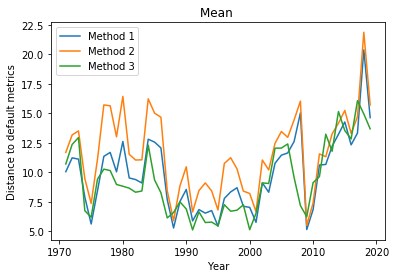

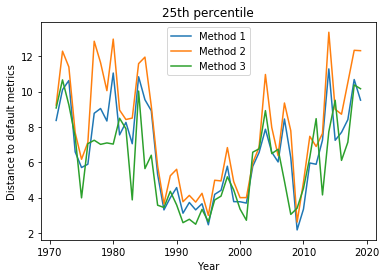

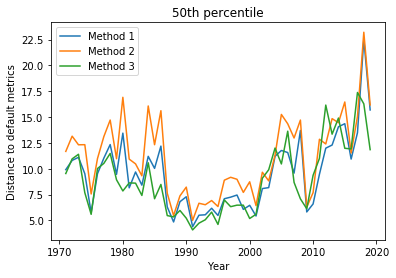

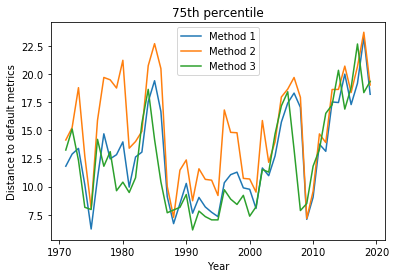

In [100]:
plot_2(DD_mean_FINAL.iloc[:,0], DD_mean_FINAL.iloc[:,2],DD_mean_FINAL.iloc[:,4],"Mean ")
plot_2(DD_25th_FINAL.iloc[:,0],DD_25th_FINAL.iloc[:,2],DD_25th_FINAL.iloc[:,4],"25th percentile")
plot_2(DD_50th_FINAL.iloc[:,0], DD_50th_FINAL.iloc[:,2], DD_50th_FINAL.iloc[:,4], "50th percentile")
plot_2(DD_75th_FINAL.iloc[:,0], DD_75th_FINAL.iloc[:,2], DD_75th_FINAL.iloc[:,4],"75th percentile" )

## Desc Stats Setting up NBER

In [102]:
NBER = pd.read_csv('D://Data/USREC.csv', header = 0)
NBER['DATE'] = pd.to_datetime(NBER['DATE'])
NBER['FYEAR'] = pd.DatetimeIndex(NBER['DATE']).year
NBER['FYEARD'] = NBER['FYEAR']
NBER = NBER.iloc[1:]
AVG_NBER = NBER.groupby('FYEAR').mean().round()
DD_meanNBER = pd.merge(DD_mean_FINAL, AVG_NBER, how='inner', left_on=['FYEAR'],right_on = ['FYEARD'])
DD_meanNBER.set_index("FYEARD", inplace=True)

In [103]:
DD_meanNBER[DD_meanNBER['USREC'] == 0].describe()

,DDNaive1,ProbDDNaive1,DDMethod2,ProbDDMethod2,DD3,ProbDD3,USREC
count,45.000000,4.500000e+01,45.000000,4.500000e+01,45.000000,4.500000e+01,45.0
mean,9.895289,8.127945e-03,11.705193,9.861714e-03,9.475997,1.350520e-02,0.0
std,3.077044,1.389642e-02,3.380518,1.729398e-02,2.988073,1.835643e-02,0.0
min,5.155745,4.298766e-22,5.498929,2.979838e-29,5.123551,3.377264e-24,0.0
25%,7.527082,3.173049e-07,8.844523,2.461531e-09,6.794101,4.105526e-06,0.0
50%,10.044122,7.924103e-04,11.529717,1.859446e-04,9.101384,2.802559e-03,0.0
75%,12.068042,8.843485e-03,14.156111,1.310895e-02,12.055109,2.428862e-02,0.0
max,20.376874,5.609346e-02,21.866415,7.321970e-02,16.069438,6.808967e-02,0.0


In [104]:
DD_meanNBER[DD_meanNBER['USREC'] == 1].describe()

,DDNaive1,ProbDDNaive1,DDMethod2,ProbDDMethod2,DD3,ProbDD3,USREC
count,4.000000,4.000000,4.000000,4.000000e+00,4.000000,4.000000,4.0
mean,9.523170,0.011296,10.806658,9.073697e-03,7.194864,0.015386,1.0
std,3.962403,0.014472,3.924976,1.593953e-02,0.795572,0.025013,0.0
min,5.764142,0.000001,6.673549,4.814315e-07,6.526679,0.000009,1.0
25%,7.371746,0.000006,8.775175,7.548631e-07,6.696612,0.000544,1.0
50%,8.648430,0.007453,10.260484,1.717444e-03,6.968337,0.004529,1.0
75%,10.799854,0.018743,12.291967,1.079039e-02,7.466589,0.019371,1.0
max,15.031678,0.030278,16.032114,3.285942e-02,8.316106,0.052478,1.0


## Recession Plot

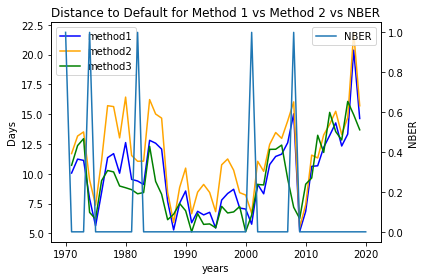

In [109]:
NBERPLOT = AVG_NBER.iloc[115:166, :1]
M1 = DD_mean_FINAL.iloc[:,0]
M2 = DD_mean_FINAL.iloc[:,2]
M3 = DD_mean_FINAL.iloc[:,4]
fig, ax1 = plt.subplots()

ax1.set_title('Distance to Default for Method 1 vs Method 2 vs NBER')
ax1.set_xlabel('years')
ax1.set_ylabel('Days')
ax1.plot(M1, color='blue', label = 'method1')
ax1.plot(M2, color='orange', label = 'method2')
ax1.plot(M3, color='green', label = 'method3')
ax1.tick_params(axis='y')
plt.legend(loc = 'upper left')
ax2 = ax1.twinx()
ax2.set_ylabel('NBER')
ax2.plot(NBERPLOT, label = "NBER")
ax2.tick_params(axis='y')
plt.legend(loc = 'upper right')
fig.tight_layout()

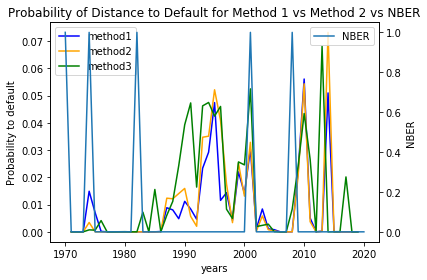

In [110]:
M1 = DD_mean_FINAL.iloc[:,1]
M2 = DD_mean_FINAL.iloc[:,3]
M3 = DD_mean_FINAL.iloc[:,5]

fig, ax1 = plt.subplots()
ax1.set_title('Probability of Distance to Default for Method 1 vs Method 2 vs NBER')
ax1.set_xlabel('years')
ax1.set_ylabel('Probability to default')
ax1.plot(M1, color='blue', label = 'method1')
ax1.plot(M2, color='orange', label = 'method2')
ax1.plot(M3, color='green', label = 'method3')
ax1.tick_params(axis='y')
plt.legend(loc = 'upper left')
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('NBER')
ax2.plot(NBERPLOT, label = "NBER")
ax2.tick_params(axis='y')
plt.legend(loc = 'upper right')
fig.tight_layout()

## Moody's BAA-Fed Fund Spread

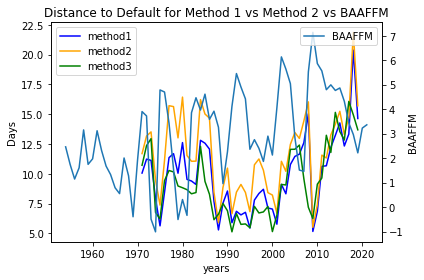

In [111]:
BAAFFM = pd.read_csv('D:/Data/BAAFFM.csv', header = 0)
BAAFFM['DATE'] = pd.to_datetime(BAAFFM['DATE'])
BAAFFM['DATE'] = pd.DatetimeIndex(BAAFFM['DATE']).year
BAAFFM = (BAAFFM.groupby(['DATE'], as_index=False).mean().groupby('DATE')['BAAFFM'].mean())

M1 = DD_mean_FINAL.iloc[:,0]
M2 = DD_mean_FINAL.iloc[:,2]
M3 = DD_mean_FINAL.iloc[:,4]
fig, ax1 = plt.subplots()
ax1.set_title('Distance to Default for Method 1 vs Method 2 vs BAAFFM')
ax1.set_xlabel('years')
ax1.set_ylabel('Days')
ax1.plot(M1, color='blue', label = 'method1')
ax1.plot(M2, color='orange', label = 'method2')
ax1.plot(M3, color='green', label = 'method3')
ax1.tick_params(axis='y')
plt.legend(loc = 'upper left')
ax2 = ax1.twinx()
ax2.set_ylabel('BAAFFM')
ax2.plot(BAAFFM, label = "BAAFFM")
ax2.tick_params(axis='y')
plt.legend(loc = 'upper right')
fig.tight_layout()

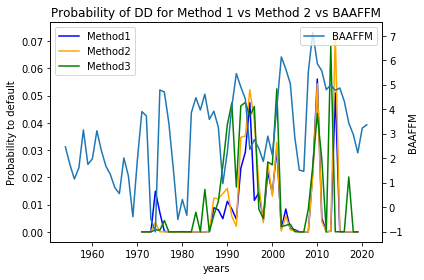

In [113]:
M1 = DD_mean_FINAL.iloc[:,1]
M2 = DD_mean_FINAL.iloc[:,3]
M3 = DD_mean_FINAL.iloc[:,5]
fig, ax1 = plt.subplots()
ax1.set_title('Probability of DD for Method 1 vs Method 2 vs BAAFFM')
ax1.set_xlabel('years')
ax1.set_ylabel('Probability to default')
ax1.plot(M1, color='blue', label = 'Method1')
ax1.plot(M2, color='orange', label = 'Method2')
ax1.plot(M3, color='green', label = 'Method3')
ax1.tick_params(axis='y')
plt.legend(loc = 'upper left')
ax2 = ax1.twinx()
ax2.set_ylabel('BAAFFM')
ax2.plot(BAAFFM, label = 'BAAFFM')
ax2.tick_params(axis='y')
plt.legend(loc = 'upper right')
fig.tight_layout()

## Cleveland Financial Stress Index

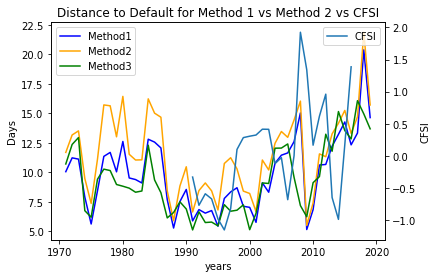

In [114]:
CFSI = pd.read_csv('D:/Data/CFSI.csv', header = 0)
CFSI['DATE'] = pd.to_datetime(CFSI['DATE'])
CFSI['DATE'] = pd.DatetimeIndex(CFSI['DATE']).year
CFSI = (CFSI.groupby(['DATE'], as_index=False).mean().groupby('DATE')['CFSI'].mean())

M1 = DD_mean_FINAL.iloc[:,0]
M2 = DD_mean_FINAL.iloc[:,2]
M3 = DD_mean_FINAL.iloc[:,4]
fig, ax1 = plt.subplots()
ax1.set_title('Distance to Default for Method 1 vs Method 2 vs CFSI')
ax1.set_xlabel('years')
ax1.set_ylabel('Days')
ax1.plot(M1, color='blue', label = 'Method1')
ax1.plot(M2, color='orange', label = 'Method2')
ax1.plot(M3, color='green', label = 'Method3')
ax1.tick_params(axis='y')
plt.legend(loc = 'upper left')
ax2 = ax1.twinx()
ax2.set_ylabel('CFSI')
ax2.plot(CFSI, label = 'CFSI')
ax2.tick_params(axis='y')
plt.legend(loc = 'upper right')

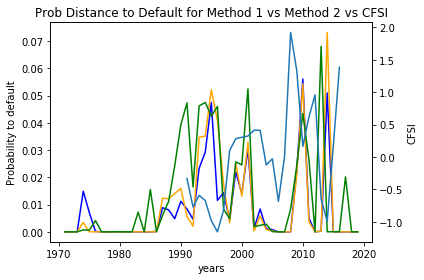

In [115]:
M1 = DD_mean_FINAL.iloc[:,1]
M2 = DD_mean_FINAL.iloc[:,3]
M3 = DD_mean_FINAL.iloc[:,5]
fig, ax1 = plt.subplots()
ax1.set_title('Prob Distance to Default for Method 1 vs Method 2 vs CFSI')
ax1.set_xlabel('years')
ax1.set_ylabel('Probability to default')
ax1.plot(M1, color='blue', label = 'Method1')
ax1.plot(M2, color='orange', label = 'Method2')
ax1.plot(M3, color='green', label = 'Method3')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.set_ylabel('CFSI')
ax2.plot(CFSI, label = 'CFSI')
ax2.tick_params(axis='y')
fig.tight_layout()